# Comparing Calibration Data Across All Models / Question Sets

In [1]:
%%capture
%pip install -r requirements.txt

In [2]:
# Initialize
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from pathlib import Path
import json


## Combine All Results Into Composite CSV

First we will read from the Parsed Results folder and make a dictionary that abstracts the structure of the directory

In [3]:
# Read the folder and create a dictionary to model the structure of the files

def folder_tree_dict(root, *, include_files=True, follow_symlinks=False, ignore_hidden=True):
    root = Path(root)

    def build(p: Path):
        out = {}
        for entry in sorted(p.iterdir(), key=lambda x: (x.is_file(), x.name.lower())):
            if ignore_hidden and entry.name.startswith("."):
                continue
            try:
                if entry.is_dir() and (follow_symlinks or not entry.is_symlink()):
                    out[entry.name] = build(entry)
                else:
                    if include_files:
                        out[entry.name] = None  # or {"size": entry.stat().st_size}
            except PermissionError:
                out[entry.name] = "<permission-denied>"
        return out

    return {root.name: build(root)}


folder_path = r"Parsed Results"

folder_abstraction_dict = folder_tree_dict(folder_path)[folder_path]

folder_abstraction_dict.keys()

dict_keys(['Claude', 'Deepseek', 'Gemini', 'GPT', 'Llama'])

### Combined CSV
We want to make a well-formed CSV for future analysis. This CSV will have the following fields for columns:

```text
Question Set (str) ---------------- Required: The display name of the question set
Question ID (str) ----------------- Required: The Question ID
Model (str) ----------------------- Required: The model that provided the response (e.g. Llama-3.1-8B-Instruct)
Model Type (str) ------------------ Required: The family of models which  the model (e.g. Llama)
Coerce (Bool) --------------------- Required: Whether the parser was able to understand the response

Question (str) -------------------- Required: The question posed to the model
Correct Answer (str) -------------- Optional: Depends on Question Set (LifeEval is different than others)
Content (str) --------------------- Optional: Depends on Coerce value (NA if Coerce == False)
Reasoning (str) ------------------- Optional: Depends on Coerce value (NA if Coerce == False)
Answer (str) ---------------------- Optional: Depends on Coerce value (NA if Coerce == False)
Score (float) --------------------- Optional: Depends on Coerce value (NA if Coerce == False)

Stated Confidence Answer (float) -- Optional: Depends on Question Set (NA if not available)
Stated Confidence A (float) ------- Optional: Depends on Question Set (NA if not available)
Stated Confidence B (float) ------- Optional: Depends on Question Set (NA if not available)
Stated Confidence C (float) ------- Optional: Depends on Question Set (NA if not available)
Stated Confidence D (float) ------- Optional: Depends on Question Set (NA if not available)
Stated Confidence E (float)-------- Optional: Depends on Question Set (NA if not available)

Token Probability Answer (float) -- Optional: Depends on Model Type (NA if not available)
Token Probability A (float) ------- Optional: Depends on Model Type (NA if not available)
Token Probability B (float) ------- Optional: Depends on Model Type (NA if not available)
Token Probability C (float) ------- Optional: Depends on Model Type (NA if not available)
Token Probability D (float) ------- Optional: Depends on Model Type (NA if not available)
Token Probability E (float) ------- Optional: Depends on Model Type (NA if not available)

```

---
### Process All CSVs Into One

### Grading:

In [4]:
## Life Eval
import math as m
mcq_qsets = ['LSAT-AR', 'SAT-EN', 'SciQ']


def get_age(qid: int) -> int:
    if qid < 404:
        return m.floor(
            abs(
                (qid) / 4
                )
            )
    else:
        return m.floor(
            abs(
                (qid - 404) / 4
                )
            )

def compute_prob(point_estimate: float,
                 R: float,
                 gender: str,          # 'male' or 'female' (case-insensitive)
                 min_age: int,         # condition "already lived at least min_age"
                 df: pd.DataFrame) -> float:
    """
    Using a life table with columns:
      - 'Age'
      - 'Death probability (MALE)'
      - 'Death probability (FEMALE)'
    compute P(death occurs within [point_estimate - R, point_estimate + R] | survived to min_age).
    """

    if "Age" not in df.columns:
        raise ValueError("Expected an 'Age' column in the life table.")

    g = gender.strip().lower()
    if g not in ("male", "female"):
        raise ValueError("gender must be 'male' or 'female'")

    qx_col_map = {
        "male":   "Death probability (MALE)",
        "female": "Death probability (FEMALE)",
    }
    qx_col = qx_col_map[g]
    if qx_col not in df.columns:
        raise ValueError(f"Expected column '{qx_col}' in the life table.")


    # Work on a clean copy sorted by Age
    global tab
    tab = df[["Age", qx_col]].copy().sort_values("Age").reset_index(drop=True).dropna()
    tab.rename(columns={qx_col: "q"}, inplace=True)
    tab["Age"] = tab["Age"].astype(int)
    tab["q"] = tab["q"].astype(float)

    # Integer-age window [lo, hi), clamped to table bounds and min_age
    table_min = int(tab["Age"].min())
    table_max = int(tab["Age"].max())  # last age with q_x for [x, x+1)
    lo = max(int(np.floor(point_estimate - R)), int(min_age), table_min)
    hi = min(int(np.ceil(point_estimate + R)), table_max + 1)  # exclusive upper bound

    if hi <= lo:
        return 0.0

    # Align to contiguous ages and extract q_x as numpy
    ages = np.arange(table_min, table_max + 1, dtype=int)
    sub = tab.set_index("Age").reindex(ages)
    if sub["q"].isna().any():
        # restrict to contiguous valid block if necessary
        valid = sub["q"].notna()
        first = int(ages[valid.argmax()])
        last = int(ages[::-1][valid.iloc[::-1].argmax()])
        lo = max(lo, first)
        hi = min(hi, last + 1)
        if hi <= lo:
            return 0.0
        sub = sub.loc[first:last]
        ages = sub.index.values

    q = sub["q"].to_numpy()
    offset = int(ages[0])

    # Survival from min_age (m)
    m = max(int(min_age), int(ages[0]))
    if m >= hi:
        return 0.0

    one_minus_q = 1.0 - q
    start = m - offset
    end_excl = hi - offset

    # Relative survival S_rel(x) = Π_{k=m}^{x-1} (1-q_k), with S_rel(m)=1
    S_rel = np.ones(end_excl - start + 1, dtype=float)
    if end_excl - start > 0:
        S_rel[1:] = np.cumprod(one_minus_q[start:end_excl])

    # Sum P(T in [x, x+1) | T >= m) = S_rel(x) * q_x for x = max(lo,m) .. hi-1
    x0 = max(lo, m)
    xs = np.arange(x0, hi, dtype=int)
    if xs.size == 0:
        return 0.0

    idx = xs - offset
    S_rel_x = S_rel[(xs - m)]
    q_x = q[idx]
    prob = float(np.sum(S_rel_x * q_x))

    # Clamp for numerical safety
    return max(0.0, min(1.0, prob))

def score_life_eval(df, act_table):
    answers = df['Answer']
    
    #confidence = df['Stated Confidence'].astype(float)
    qid = df['Question ID']

    # Get Radius
    radius_list = [1, 5, 10, 20]
    # Get the modulus of QID then use that as an index for radius_list such that 0-> 1, 1-> 5, 2-> 10, 3-> 20
    mod_qid = df['Question ID'].astype('int').apply(lambda x: x % 4)


    rads = qid_to_rads(qid)
    #df['radius'] = rads

    #Gold Answer:

    all_data = pd.DataFrame({
        'Question ID': qid,
        'Answer': answers,
        #'Confidence': confidence.astype(float),
        'Radius': rads,
    })

    data = all_data[all_data['Answer'].notna()].copy()
    data['Gender'] = ['female' if i >= 404 else 'male' for i in data.index]
    data['Age'] = [get_age(qid) for qid in data['Question ID']]


    data['Score'] = data.apply(lambda row: compute_prob(
        point_estimate= row['Answer'],
        min_age= row['Age'],
        gender= row['Gender'],
        R= row['Radius'],
        df = act_table
        ),
        axis = 1
        )


    #data['Overconfidence'] = (data['Confidence'] - data['Score'])
    return data["Score"]

def qid_to_rads(qid: pd.Series)-> pd.Series:
    radius_list = [1, 5, 10, 20]
    mod_qid = qid.astype('int').apply(lambda x: x % 4)
    rads = mod_qid.apply(lambda i: radius_list[i])
    return rads

In [5]:
def grade_df(source_df, gold_df, qset_name):
    df = source_df.copy()
    mask = df.index
    #print(f"            Length: {len(mask)}")
    
    if qset_name in mcq_qsets:
        # Make sure the QIDs are in the right order
        df["Question ID"] = df["Question ID"].astype(int) 
        df = df.sort_values(by="Question ID", ascending=True).reset_index()
        df["Question ID"] = df["Question ID"].astype(str)  ## make sure back as str for downstream tasks

        gold_df["Question ID"] = gold_df["Question ID"].astype(str)
        temp = pd.merge(source_df, gold_df, on = "Question ID")
        scores = (temp["Answer"].str.lower().str.strip() == temp["Correct Answer Letter"].str.lower().str.strip()).astype(float)
        df["Score"] = scores
        df['Correct Answer'] = temp["Correct Answer Letter"].str.upper().str.strip()

        # assumes stated confidences live in columns ["A","B","C","D"]
        if qset_name == "LSAT-AR":
            opt_cols = ["A","B","C","D", "E"]
            # normalize answer letters
            ans = df["Answer"].astype("string").str.strip().str.upper()

            # map letters to column indices
            idx = ans.map({"A":0, "B":1, "C":2, "D":3, "E":4 }).to_numpy()
        else:
            opt_cols = ["A","B","C","D"]
            # normalize answer letters
            ans = df["Answer"].astype("string").str.strip().str.upper()

            # map letters to column indices
            idx = ans.map({"A":0, "B":1, "C":2, "D":3}).to_numpy()

        vals = df[opt_cols].apply(pd.to_numeric, errors="coerce").to_numpy()
        mask = ~np.isnan(idx)

        chosen = np.full(len(df), np.nan, dtype=float)
        chosen[mask] = vals[mask, idx[mask].astype(int)]
        df["Stated Confidence Answer (MCQ)"] = chosen


    elif qset_name == "BoolQ":
        # Make sure the QIDs are in the right order
        # df["Question ID"] = df["Question ID"].astype(int) 
        # df = df.sort_values(by="Question ID", ascending=True).reset_index()
        # df["Question ID"] = df["Question ID"].astype(str)  ## make sure back as str for downstream tasks

        gold_df["Question ID"] = gold_df["Question ID"].astype(str)
        temp = pd.merge(source_df, gold_df, on = "Question ID")

        bscores = (temp["Answer"].astype(str) == temp["Correct Answer"].astype(str)).astype(float)
        df["Score"] = bscores
        df['Correct Answer'] = temp["Correct Answer"].astype(str)
        
    elif qset_name == "LifeEval":
        df["Question ID"]= df["Question ID"].astype(int)
        df["Score"] = score_life_eval(df, gold_df)
        df["Question ID"]=df["Question ID"].astype(str)
    elif qset_name == "HaluEval":
        df["Score"] = df["Question ID"].str.contains("_r").astype(float)
    else:
        df["Score"] = "UNRECOGINIZED QUESTION SET"
    """
    Don wants: one column that indicates stated confidence in the correct answer, with remaining 
    in correct answers in different columns.
    (It would of course follow that token prob should be reorganized the same way.) 

    Currently we evaluate the whether the answer was correct and then the confidence it was assigned. Is this different?
    Don's Approach: Grade the question based off of the correct answer.
    My Approach: Grade the question based off of the chosen answer.
    """
    #print(f"            Length: {len(df)}")
    return df

### Combining:

In [6]:
combined_df = pd.DataFrame()
clean_df = pd.DataFrame()

qset_rename = {
 'boolq_valid': "BoolQ",
 'halu_eval_qa': "HaluEval",
 'life_eval': "LifeEval",
 'lsat_ar_test': "LSAT-AR",
 'sat_en': "SAT-EN",
 'sciq_test':"SciQ"
}

gold_paths = {
    "BoolQ": r"Formatted Benchmarks\boolq_valid_formatted.csv",
    "HaluEval": r"Formatted Benchmarks\halu_eval_qa_formatted.csv",
    "LifeEval":    r"Formatted Benchmarks\PeriodLifeTable_2022_RawData.csv",
    "LSAT-AR": r"Formatted Benchmarks\lsat_ar_test_formatted.csv", 
    "SAT-EN": r"Formatted Benchmarks\sat_en_formatted.csv",
    "SciQ": r"Formatted Benchmarks\sciq_test_formatted.csv"    
}


mcq_qsets = ['LSAT-AR', 'SAT-EN', 'SciQ']


for model_type, models in folder_abstraction_dict.items():
    model_type_path = folder_path + f"/{model_type}"
    print(model_type_path)
    for model_name, qsets in models.items():
        model_path = model_type_path + f"/{model_name}"
        print(f"    {model_path}")
        for qset_file_name in qsets:
            splitter = f"_{model_name}"
            qset_name = qset_file_name.split(splitter)[0]
            qset_path = model_path + f"/{qset_file_name}"
            
            #--------- Write a function to spit out a dataframe w/ model_name, qset_name, true_answer and concat it

            source_df = pd.read_csv(qset_path)


            print(f"        {qset_name}    ")

            source_df["Model"] = model_name
            source_df["Model Type"] = model_type

            qset_display = qset_rename[qset_name]
            source_df["Question Set"] = qset_display
            source_df["Question ID"] = source_df["Question ID"].astype(str)

            gold_df_path = gold_paths[qset_display]

            gold_df = pd.read_csv(gold_df_path)
            
            scored_qset = grade_df(source_df = source_df, gold_df = gold_df, qset_name= qset_display)

            combined_df = pd.concat([combined_df, scored_qset], ignore_index=True)




combined_df.drop(["Unnamed: 0", "Question ID.1"], axis = 1, inplace = True, errors = "ignore")

## Still need to add correct answer and score

col_rename_map ={
# Metadata
'Question Set': "Question Set",
'Question ID': "Question ID",
'Model': "Model",
'Model Type': "Model Type",
'coerce': "Coerce",

# Model Response

'content': "Content",
'Reasoning': "Reasoning",
'Answer': "Answer",

# Stated Confidence
'Confidence': "Stated Confidence Answer",
"A": "Stated Confidence A",
"B": "Stated Confidence B",
'C': "Stated Confidence C",
'D': "Stated Confidence D",
'E': "Stated Confidence E",

# Token Probability
'True_prob': "Token Probability True",
'False_prob': "Token Probability False",
'Answer_prob': "Token Probability Answer",
'A_prob': "Token Probability A",
'B_prob': "Token Probability B",
'C_prob': "Token Probability C",
'D_prob': "Token Probability D",
'E_prob': "Token Probability E"
}

combined_df = combined_df.rename(columns = col_rename_map)

qset_rename = {
 'boolq_valid': "BoolQ",
 'halu_eval_qa': "HaluEval",
 'life_eval': "LifeEval",
 'lsat_ar_test': "LSAT-AR",
 'sat_en': "SAT-EN",
 'sciq_test':"SciQ"
}

#combined_df["Question Set"] = combined_df["Question Set"].map(qset_rename)

with pd.option_context('display.max_columns', None,
                       #'display.width', None,
                       #'display.max_colwidth', None
                       ):
    display(combined_df.head(5))

Parsed Results/Claude
    Parsed Results/Claude/claude-3-7-sonnet-20250219
        boolq_valid    
        halu_eval_qa    
        life_eval    
        lsat_ar_test    
        sat_en    
        sciq_test    
    Parsed Results/Claude/claude-3-haiku-20240307
        boolq_valid    
        halu_eval_qa    
        life_eval    
        lsat_ar_test    
        sat_en    
        sciq_test    
    Parsed Results/Claude/claude-sonnet-4-20250514
        boolq_valid    
        halu_eval_qa    
        life_eval    
        lsat_ar_test    
        sat_en    
        sciq_test    
Parsed Results/Deepseek
    Parsed Results/Deepseek/deepseek-r1
        boolq_valid    
        halu_eval_qa    
        life_eval    
        lsat_ar_test    
        sat_en    
        sciq_test    
    Parsed Results/Deepseek/deepseek-v3
        boolq_valid    
        halu_eval_qa    
        life_eval    
        lsat_ar_test    
        sat_en    
        sciq_test    
Parsed Results/Gemini
    Parsed Re

,Reasoning,Answer,Stated Confidence Answer,Coerce,Content,Question ID,Model,Model Type,Question Set,Score,Correct Answer,index,Stated Confidence A,Stated Confidence B,Stated Confidence C,Stated Confidence D,Stated Confidence E,Stated Confidence Answer (MCQ),Token Probability True,Token Probability False,Token Probability Answer,Token Probability A,Token Probability B,Token Probability C,Token Probability D,Token Probability E
0,The question is asking whether the production ...,False,0.6,True,"{\n ""Reasoning"": ""The question is asking wh...",0,claude-3-7-sonnet-20250219,Claude,BoolQ,1.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,House tax and property tax are often used inte...,True,0.85,True,"{\n ""Reasoning"": ""House tax and property ta...",1,claude-3-7-sonnet-20250219,Claude,BoolQ,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,This question is asking about phantom limb pai...,True,0.95,True,"{\n ""Reasoning"": ""This question is asking a...",2,claude-3-7-sonnet-20250219,Claude,BoolQ,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Harry Potter and the Escape from Gringotts is ...,True,0.98,True,"{\n ""Reasoning"": ""Harry Potter and the Esca...",3,claude-3-7-sonnet-20250219,Claude,BoolQ,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Hydroxyzine HCl (hydrochloride) and hydroxyzin...,True,0.98,True,"{\n ""Reasoning"": ""Hydroxyzine HCl (hydrochl...",4,claude-3-7-sonnet-20250219,Claude,BoolQ,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Clean DataFrame

In [7]:
combined_clean = combined_df.copy()
combined_clean['combined_name'] = combined_clean['Question ID'] + "_" + combined_clean["Question Set"]

s = combined_clean["combined_name"].value_counts() % 11  #---------------- This seems to get rid of too much
bad_qid = s.index[s.ne(0)].tolist()  

combined_clean = combined_clean[~combined_clean["combined_name"].isin(bad_qid)]


# this gets the qid and qset where coerce is false
bad_qid_qset = combined_df[
    (combined_df["Coerce"] == False) | 
    (combined_df["Stated Confidence Answer"].astype(str).str.isnumeric())
    ][["Question ID", "Question Set"]]

#bad_qid_qset = bad_qid_qset[["Question ID", "Question Set"]]

bad = set(bad_qid_qset["Question ID"] +  "_" + bad_qid_qset["Question Set"])

mask = ~combined_clean["combined_name"].isin(bad)   # True = keep

combined_clean = combined_clean[mask]


## Clean up MCQ Question Sets
cc = combined_clean[combined_clean["Question Set"].isin(mcq_qsets)]
cc_letters = cc[["Stated Confidence A", "Stated Confidence B", "Stated Confidence C","Stated Confidence D","Stated Confidence E",]].copy()
sum_confidence = cc_letters.sum(axis = 1)

con_mask = cc[sum_confidence == 0.0]["combined_name"]

# Indixes that aren't in con_mask
combined_clean = combined_clean.loc[~combined_clean["combined_name"].isin(con_mask)]

#---------------------------------------------------------------------------------------------
## Special mask for LifeEval:

le_df = combined_clean[combined_clean["Question Set"] == "LifeEval"]

con_isnum = pd.to_numeric( le_df['Stated Confidence Answer'], errors='coerce').notna()
le_bad_qid= le_df[~con_isnum]["combined_name"]


combined_clean = combined_clean[(~combined_clean["combined_name"].isin(le_bad_qid)) ]

## Finally, rename the Models for readability


model_names = {
    "gpt-4o": "GPT-4o",
    "o3-2025-04-16": "GPT-o3",
    "claude-sonnet-4-20250514": "Claude-Sonnet-4",
    "claude-3-7-sonnet-20250219": "Claude-Sonnet-3.7",
    "claude-3-haiku-20240307": "Claude Haiku 3",
    "gemini-2.5-pro": "Gemini-2.5-Pro",
    "gemini-2.5-flash": "Gemini-2.5-Flash",
    "Meta-Llama-3.1-8B-Instruct": "Llama-3.1-8B",
    "Meta-Llama-3.1-70B-Instruct": "Llama-3.1-70B",
    "deepseek-r1": "DeepSeek-R1",
    "deepseek-v3": "DeepSeek-V3",
}

combined_clean['Model'] = combined_clean['Model'].map(model_names)

display(combined_clean.head(5))
combined_clean.shape

,Reasoning,Answer,Stated Confidence Answer,Coerce,Content,Question ID,Model,Model Type,Question Set,Score,...,Stated Confidence Answer (MCQ),Token Probability True,Token Probability False,Token Probability Answer,Token Probability A,Token Probability B,Token Probability C,Token Probability D,Token Probability E,combined_name
0,The question is asking whether the production ...,False,0.6,True,"{\n ""Reasoning"": ""The question is asking wh...",0,Claude-Sonnet-3.7,Claude,BoolQ,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_BoolQ
2,This question is asking about phantom limb pai...,True,0.95,True,"{\n ""Reasoning"": ""This question is asking a...",2,Claude-Sonnet-3.7,Claude,BoolQ,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2_BoolQ
3,Harry Potter and the Escape from Gringotts is ...,True,0.98,True,"{\n ""Reasoning"": ""Harry Potter and the Esca...",3,Claude-Sonnet-3.7,Claude,BoolQ,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3_BoolQ
4,Hydroxyzine HCl (hydrochloride) and hydroxyzin...,True,0.98,True,"{\n ""Reasoning"": ""Hydroxyzine HCl (hydrochl...",4,Claude-Sonnet-3.7,Claude,BoolQ,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4_BoolQ
5,Barq's Root Beer is not a Pepsi product. It is...,False,0.98,True,"{\n ""Reasoning"": ""Barq's Root Beer is not a...",5,Claude-Sonnet-3.7,Claude,BoolQ,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5_BoolQ


(69278, 27)

# Summary Info

Here we see the Raw versus Filtered counts for all the datasets.

In [8]:
counts = pd.DataFrame({
    "Raw": combined_df["Question Set"].value_counts() / 11, # This is slightly below 2000 for Llama because we had to drop 3 duplicates
    "Filtered": combined_clean["Question Set"].value_counts() / 11
})

counts[~counts.index.isin(mcq_qsets)]

counts["Prop. Kept"] = counts["Filtered"] / counts["Raw"]
counts
# Need to look at: LSAT-AR (-1)???,  Sciq(-1) Im getting rid of too much?

,Raw,Filtered,Prop. Kept
Question Set,,,
BoolQ,3270.000000,2503.0,0.765443
HaluEval,1998.909091,1790.0,0.895488
LSAT-AR,229.909091,86.0,0.374061
LifeEval,808.000000,751.0,0.929455
SAT-EN,206.000000,173.0,0.839806
SciQ,1000.000000,995.0,0.995000


In [9]:
combined_df[combined_df["Coerce"] == True].pivot_table(index="Model", columns="Question Set",
                        aggfunc="size", fill_value=0)

Question Set,BoolQ,HaluEval,LSAT-AR,LifeEval,SAT-EN,SciQ
Model,,,,,,
Meta-Llama-3.1-70B-Instruct,3241,1960,208,807,202,1000
Meta-Llama-3.1-8B-Instruct,3200,1997,190,800,202,997
claude-3-7-sonnet-20250219,3267,2000,228,808,206,999
claude-3-haiku-20240307,3036,1855,230,808,181,999
claude-sonnet-4-20250514,3258,2000,188,808,205,1000
deepseek-r1,3214,2000,228,808,206,1000
deepseek-v3,2898,2000,228,808,204,1000
gemini-2.5-flash,3261,2000,177,808,206,1000
gemini-2.5-pro,3190,1984,188,808,204,1000


---
We had some notable differences from Jacob's results in **LSAT-AR** and **SciQ**. Let's take a look.

In [10]:
sciq_filtered = combined_clean[combined_clean["Question Set"] == "SciQ"]
sciq_raw = combined_df[combined_df["Question Set"] == "SciQ"]


sciq_filtered_ids = sciq_filtered.index

deleted = sciq_raw[~sciq_raw.index.isin(sciq_filtered_ids)]
deleted["Question ID"].unique()

# Deleted QID in SciQ are ['13', '40', '295', '699', '705'] after visual inspection they all seem to have False coerce values in one of 11 rows


false_counts = (deleted['Coerce'].eq(False)
                .groupby(deleted['Question ID'])
                .sum()
                .rename('false_count'))

# as a DataFrame
false_counts = false_counts.reset_index()
false_counts


,Question ID,false_count
0,13,1
1,295,1
2,40,1
3,699,1
4,705,1


Jacob's cleaned version of SciQ has 996 QIDs while mine has 995. When investigating each deleted Question ID in my version we find that they all have 1 instance where the answer could not be coerced. Does Jacob have an extra question that shouldn't be there?

---
Looking at LSAT-AR we see that Jacob had 87 QIDs while mine had 86. Let's investigate the difference.

In [11]:

lsat_filtered = combined_clean[combined_clean["Question Set"] == "LSAT-AR"]
lsat_raw = combined_df[combined_df["Question Set"] == "LSAT-AR"]


lsat_filtered_ids = lsat_filtered.index

deleted = lsat_raw[~lsat_raw.index.isin(lsat_filtered_ids)]
deleted["Question ID"].unique()



false_counts = (deleted['Coerce'].eq(False)
                .groupby(deleted['Question ID'])
                .sum()
                .rename('false_count'))

# as a DataFrame
false_counts = false_counts.reset_index()

# There is one QID that was removed while having all coerce values as True. Lets investigate:
special_qid = list(false_counts[false_counts['false_count'] == 0]['Question ID'])
print(f"Special Question IDs: {special_qid}")

# At some point QID 64
bad_qid_confidence = lsat_raw[lsat_raw['Question ID'].isin(special_qid)][["Question ID", "Coerce", "Model", "Stated Confidence A", "Stated Confidence B", "Stated Confidence C","Stated Confidence D","Stated Confidence E",]]#.sum(axis =1)

bad_qid_confidence['Sum'] = bad_qid_confidence.sum(axis=1, numeric_only = True)
bad_qid_confidence

Special Question IDs: ['64']


,Question ID,Coerce,Model,Stated Confidence A,Stated Confidence B,Stated Confidence C,Stated Confidence D,Stated Confidence E,Sum
6142,64,True,claude-3-7-sonnet-20250219,0.050,0.050,0.050,0.05,0.800,2.0
13656,64,True,claude-3-haiku-20240307,0.000,0.000,0.500,0.50,0.000,2.0
21170,64,True,claude-sonnet-4-20250514,0.100,0.100,0.100,0.10,0.600,2.0
28684,64,True,deepseek-r1,0.000,0.000,0.000,1.00,0.000,2.0
36198,64,True,deepseek-v3,0.000,1.000,0.000,0.00,0.000,2.0
43712,64,True,gemini-2.5-flash,0.050,0.050,0.050,0.80,0.050,2.0
51226,64,True,gemini-2.5-pro,0.005,0.005,0.005,0.98,0.005,2.0
58740,64,True,gpt-4o,0.100,0.700,0.050,0.10,0.050,2.0
73758,64,True,Meta-Llama-3.1-70B-Instruct,0.000,0.000,1.000,0.00,0.000,2.0
81269,64,True,Meta-Llama-3.1-8B-Instruct,0.800,0.900,0.800,0.90,0.900,5.3


Question ID 64 in LSAT-AR only had 10 answered instances. Notably, GPT-o3 failed to respond. Because of this, we dropped it from the analysis.

In [12]:
# Jacob's file:

jb_df = pd.read_csv("Combined Results\llm-confidence-correct.csv")
jb_df.shape, combined_clean.shape

## SciQ
jb_qid = jb_df[jb_df["qset"] == "sciq_test"]["question_id"].unique()
my_qid = combined_clean[combined_clean["Question Set"] == "SciQ"]["Question ID"].unique()

# elements not in the intersection (i.e., in exactly one array)
not_in_intersection = np.setxor1d(jb_qid, my_qid)

# if you also want side-specific lists:
only_in_jb = np.setdiff1d(jb_qid, my_qid)
only_in_me = np.setdiff1d(my_qid, jb_qid)

only_in_jb


## LSAT-AR
jb_qid = jb_df[jb_df["qset"] == "lsat_ar_test"]["question_id"].unique()
my_qid = combined_clean[combined_clean["Question Set"] == "LSAT-AR"]["Question ID"].unique()

# elements not in the intersection (i.e., in exactly one array)
not_in_intersection = np.setxor1d(jb_qid, my_qid)

# if you also want side-specific lists:
only_in_jb = np.setdiff1d(jb_qid, my_qid)
only_in_me = np.setdiff1d(my_qid, jb_qid)

print(f"Unique Question IDs for LSAT-AR in Jacob's Work: {only_in_jb}")

Unique Question IDs for LSAT-AR in Jacob's Work: ['1' '102' '110' '111' '113' '114' '116' '117' '118' '119' '12' '120'
 '121' '124' '125' '126' '129' '13' '133' '134' '136' '137' '138' '140'
 '143' '146' '148' '149' '150' '151' '152' '153' '154' '156' '157' '158'
 '159' '161' '164' '165' '167' '168' '169' '170' '171' '173' '174' '175'
 '176' '177' '179' '18' '183' '186' '187' '188' '19' '190' '191' '192'
 '193' '194' '195' '196' '197' '198' '199' '200' '201' '206' '208' '209'
 '21' '210' '214' '215' '217' '218' '22' '221' '223' '224' '225' '226'
 '227' '229' '23' '25' '26' '28' '31' '32' '33' '34' '36' '37' '38' '39'
 '40' '41' '42' '44' '45' '46' '47' '48' '49' '50' '51' '52' '54' '55'
 '56' '57' '58' '59' '6' '60' '62' '63' '64' '65' '66' '67' '68' '69' '70'
 '72' '74' '76' '78' '79' '80' '81' '82' '83' '84' '85' '86' '9' '92' '93'
 '96' '98']


<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Noam Michael\AppData\Local\Temp\ipykernel_28604\2393869354.py:3: SyntaxWarning: invalid escape sequence '\l'
  jb_df = pd.read_csv("Combined Results\llm-confidence-correct.csv")


## Save all DataFrames to CSVs



In [13]:

raw_path   = Path("Combined Results/combined_raw.csv")
clean_path = Path("Combined Results/combined_clean.csv")


# write
combined_df.to_csv(raw_path, index=False, encoding="utf-8")
combined_clean.to_csv(clean_path, index=False, encoding="utf-8")


print(f"""CSV Shapes:\n{'-'*60}
Raw: {combined_df.shape}
Cleaned: {combined_clean.shape}
      """)


CSV Shapes:
------------------------------------------------------------
Raw: (82641, 26)
Cleaned: (69278, 27)
      


In [14]:
combined_clean

,Reasoning,Answer,Stated Confidence Answer,Coerce,Content,Question ID,Model,Model Type,Question Set,Score,...,Stated Confidence Answer (MCQ),Token Probability True,Token Probability False,Token Probability Answer,Token Probability A,Token Probability B,Token Probability C,Token Probability D,Token Probability E,combined_name
0,The question is asking whether the production ...,False,0.6,True,"{\n ""Reasoning"": ""The question is asking wh...",0,Claude-Sonnet-3.7,Claude,BoolQ,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_BoolQ
2,This question is asking about phantom limb pai...,True,0.95,True,"{\n ""Reasoning"": ""This question is asking a...",2,Claude-Sonnet-3.7,Claude,BoolQ,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2_BoolQ
3,Harry Potter and the Escape from Gringotts is ...,True,0.98,True,"{\n ""Reasoning"": ""Harry Potter and the Esca...",3,Claude-Sonnet-3.7,Claude,BoolQ,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3_BoolQ
4,Hydroxyzine HCl (hydrochloride) and hydroxyzin...,True,0.98,True,"{\n ""Reasoning"": ""Hydroxyzine HCl (hydrochl...",4,Claude-Sonnet-3.7,Claude,BoolQ,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4_BoolQ
5,Barq's Root Beer is not a Pepsi product. It is...,False,0.98,True,"{\n ""Reasoning"": ""Barq's Root Beer is not a...",5,Claude-Sonnet-3.7,Claude,BoolQ,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5_BoolQ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82636,Predation is a biological process where one sp...,A,NaN,True,"{\n""Reasoning"": ""Predation is a biological pro...",995,Llama-3.1-8B,Llama,SciQ,1.0,...,0.95,NaN,NaN,NaN,0.999986,0.000003,0.000001,9.645942e-06,NaN,995_SciQ
82637,Short period comets are thought to originate f...,A,NaN,True,"{\n""Reasoning"": ""Short period comets are thoug...",996,Llama-3.1-8B,Llama,SciQ,1.0,...,0.95,NaN,NaN,NaN,0.999989,0.000004,0.000004,2.966547e-06,NaN,996_SciQ
82638,The question is asking about the developmental...,D,NaN,True,"{\n""Reasoning"": ""The question is asking about ...",997,Llama-3.1-8B,Llama,SciQ,1.0,...,1.00,NaN,NaN,NaN,0.000175,0.000042,0.000043,9.997405e-01,NaN,997_SciQ
82639,Atoms with unstable nuclei are those that have...,D,NaN,True,"{\n""Reasoning"": ""Atoms with unstable nuclei ar...",998,Llama-3.1-8B,Llama,SciQ,1.0,...,1.00,NaN,NaN,NaN,0.000015,0.000018,0.000010,9.999572e-01,NaN,998_SciQ


# Analysis

---
First lets compare ECE scores for all modelson all question sets.

In [15]:
## ECE function

def get_ece(s: pd.Series, c: pd.Series, n_bins: int = 10):
    # Ensure inputs are clean
    global score, confidence
    score = s.copy().astype(float)#.reset_index().drop('index', axis = 1)
    confidence = c.copy().astype(float)#.reset_index().drop('index', axis = 1)

    # Bin edges and assignments
    global bin_edges, bin_ids
    bin_edges = np.union1d(
        np.linspace(0.0, 1.0, n_bins + 1), 
        np.array([1.0])
        )
    bin_ids = np.digitize(confidence, bin_edges, right=True)

    ece = 0.0
    total_count = len(score)

    # Calculate ECE per bin
    for i in range(1, n_bins + 1 ):
        bin_mask = bin_ids == i
        bin_count = bin_mask.sum()
        
        if bin_count > 0:
            bin_accuracy = score[bin_mask].mean()
            bin_confidence = confidence[bin_mask].mean()
            bce = (bin_count / total_count) * abs(bin_accuracy - bin_confidence) #Bin Calibration Error
            #print(f"Bin {i} CE: {bce}")
            ece += bce 

    return ece

First, we'll need a summary dataframe with all the important information for each run.

In [16]:
sum_df = pd.DataFrame(columns= ["Question Set", "Model", "Accuracy", "ECE", "Confidence", "Overconfidence"])
all_qset_names = combined_clean["Question Set"].unique()
all_model_names = combined_clean["Model"].unique()


for qset_name in all_qset_names:
    for model_name in all_model_names:
        df  = combined_clean[(combined_clean['Question Set'] == qset_name) & (combined_clean['Model'] == model_name)].reset_index()

        if qset_name in mcq_qsets:
            s = df["Score"].astype(float)
            c = df["Stated Confidence Answer (MCQ)"].astype(float)
        else:
            s = df["Score"].astype(float)
            c = df["Stated Confidence Answer"].astype(float)

        ece = get_ece(s, c)
        oc = c.mean() - s.mean()
        row = {
            "Question Set": qset_name,
            "Model": model_name,
            "Accuracy": s.mean(),
            "ECE": ece,
            "Confidence": c.mean(),
            "Overconfidence": oc
        }

        sum_df.loc[len(sum_df)] = row



sum_df[sum_df["Question Set"].isin(['LSAT-AR'])]
#sum_df

,Question Set,Model,Accuracy,ECE,Confidence,Overconfidence
33,LSAT-AR,Claude-Sonnet-3.7,0.418605,0.390698,0.809302,0.390698
34,LSAT-AR,Claude Haiku 3,0.290698,0.433721,0.687209,0.396512
35,LSAT-AR,Claude-Sonnet-4,0.453488,0.325000,0.719186,0.265698
36,LSAT-AR,DeepSeek-R1,0.953488,0.046047,0.997209,0.043721
37,LSAT-AR,DeepSeek-V3,0.348837,0.320930,0.641860,0.293023
38,LSAT-AR,Gemini-2.5-Flash,0.965116,0.037558,0.974767,0.009651
39,LSAT-AR,Gemini-2.5-Pro,0.965116,0.014767,0.979884,0.014767
40,LSAT-AR,GPT-4o,0.360465,0.495349,0.855814,0.495349
41,LSAT-AR,GPT-o3,0.965116,0.149884,0.815233,-0.149884
42,LSAT-AR,Llama-3.1-70B,0.383721,0.523256,0.895349,0.511628


In [17]:
cc = combined_clean.copy()
cc = cc[(cc['Question Set'] == 'LSAT-AR') & (cc['Model'] == 'Gemini-2.5-Pro')]
cc

ts = cc['Score']
tc = cc['Stated Confidence Answer (MCQ)']

print(f"ECE:  {get_ece(ts, tc)}")
bin_ids

for i in np.unique(bin_ids):
    mask = bin_ids == i

    mus = ts[mask].mean()
    muc = tc[mask].mean()
    print('-'*64)
    print(f"Count for bin {i}:            {mask.sum()}")
    print(f"Mean Score for Bin {i}:       {mus}")
    print(f"Mean Confidence for Bin {i}:  {muc}")


tc[bin_ids == 10]

cc[bin_ids == 10][['Stated Confidence Answer (MCQ)','Stated Confidence A', 'Stated Confidence B', 'Stated Confidence C', 'Stated Confidence D', 'Stated Confidence E']]#.dtypes

cc['Stated Confidence Answer (MCQ)'].value_counts()

ECE:  0.014767441860465191
----------------------------------------------------------------
Count for bin 10:            86
Mean Score for Bin 10:       0.9651162790697675
Mean Confidence for Bin 10:  0.9798837209302327


Stated Confidence Answer (MCQ)
1.00    29
0.98    26
0.96    23
0.95     3
0.99     2
0.97     2
0.94     1
Name: count, dtype: int64

---
## Overconfidence Plots
Lets look at `Overconfidence` for each model side by side:

In [18]:
# Coloring 

family_palettes = {
    "GPT":      sns.color_palette("Greens", 6),
    "Claude":   sns.color_palette("Blues", 6),
    "Gemini":   sns.color_palette("Purples", 6),
    "DeepSeek": sns.color_palette("Oranges", 6),
    "Llama":    sns.color_palette("RdPu", 6),
}


melted_dict = {}
# --- Function Definitions ---
def model_family(name: str) -> str:
    s = name.lower()
    if "gpt" in s or "o3" in s:   return "GPT"
    if "claude" in s:             return "Claude"
    if "gemini" in s:             return "Gemini"
    if "deepseek" in s:           return "DeepSeek"
    if "llama" in s:              return "Llama"
    return "other"


def pick_color(name: str) -> tuple:
    fam = model_family(name)
    pal = family_palettes[fam]
    s = name.lower()
    # Prefer consistent shades for common variants:
    if fam == "GPT":
        if "gpt-4o" in s: return pal[-2]  # darker green
        if "o3" in s:     return pal[1]   # lighter green
    if fam == "Claude":
        if "sonnet" in s: return pal[-2]
        if "haiku"  in s: return pal[2]
    if fam == "Gemini":
        if "pro"   in s:  return pal[-2]
        if "flash" in s:  return pal[2]
    if fam == "DeepSeek":
        if "r1"   in s:  return pal[-2]
        if "v3" in s:  return pal[2]
    return pal[3]  # default mid shade

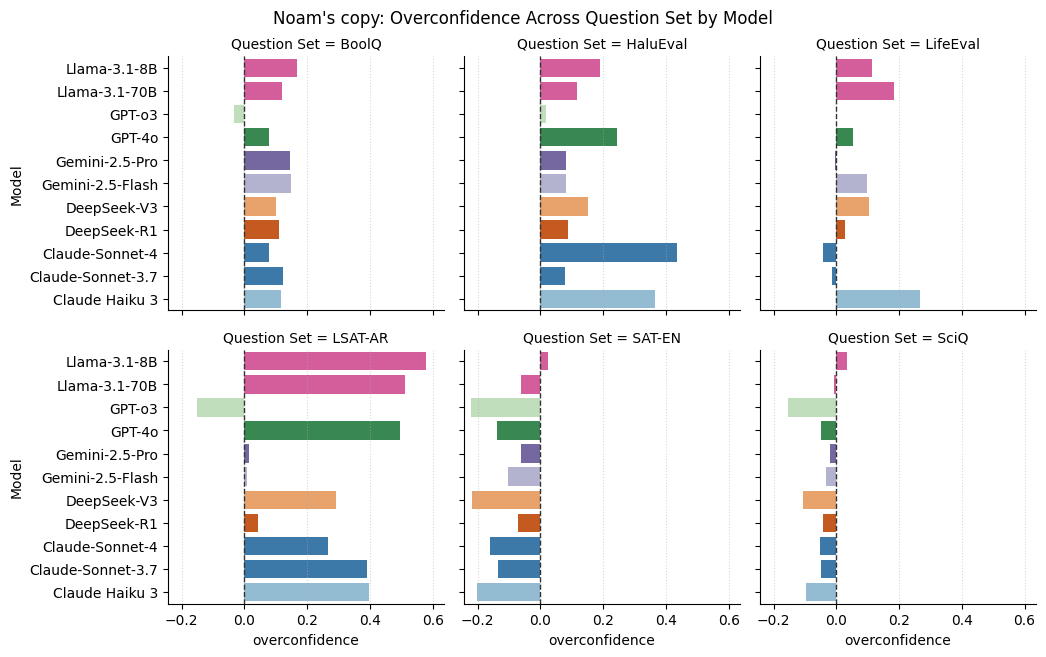

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# df has columns: "Question Set", "Model", "Overconfidence"
d = sum_df.copy()#.sort_values("Model", ascending = True)
model_order = ['Llama-3.1-8B', # Same order as Jacob
 'Llama-3.1-70B',
 'GPT-o3',
 'GPT-4o',
 'Gemini-2.5-Pro',
 'Gemini-2.5-Flash',
 'DeepSeek-V3',
 'DeepSeek-R1',
 'Claude-Sonnet-4',
 'Claude-Sonnet-3.7',
 'Claude Haiku 3'] 

palette = {m: pick_color(m) for m in sorted(d["Model"].unique(), key=str.lower)}

g = sns.catplot(
    data=d, kind="bar",
    x="Overconfidence", y="Model",
    col="Question Set", col_wrap=3,
    order=model_order, hue = "Model",
    palette = palette,
    height=3.2, aspect=1.1,# edgecolor="0.0"
)

xmin = min(-0.05, d["Overconfidence"].min()*1.1)
xmax = max( 0.05, d["Overconfidence"].max()*1.1)
g.set(xlim=(xmin, xmax), xlabel="overconfidence", ylabel="Model")

for ax in g.axes.flat:
    ax.axvline(0, linestyle="--", linewidth=1, color="0.2")
    ax.grid(True, axis="x", linestyle=":", alpha=0.5)

plt.tight_layout()
g.fig.suptitle("Noam's copy: Overconfidence Across Question Set by Model", y = 1.02)
plt.show()


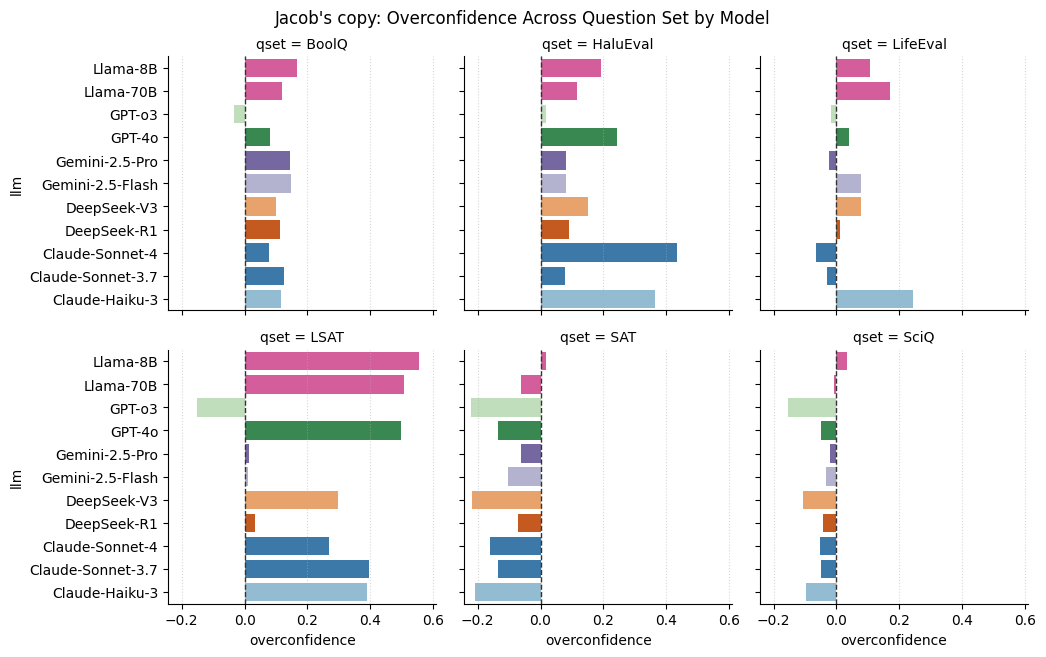

In [20]:
##
## Jacob's Version:

j = pd.read_csv(r"table1-info.csv")

qset_order = ["BoolQ", "HaluEval", "LifeEval", "LSAT", "SAT", "SciQ"]  # edit as needed
j["qset"] = pd.Categorical(j["qset"], categories=qset_order, ordered=True)

model_order = ['Llama-8B', # Same order as Jacob
 'Llama-70B',
 'GPT-o3',
 'GPT-4o',
 'Gemini-2.5-Pro',
 'Gemini-2.5-Flash',
 'DeepSeek-V3',
 'DeepSeek-R1',
 'Claude-Sonnet-4',
 'Claude-Sonnet-3.7',
 'Claude-Haiku-3'] 

palette = {m: pick_color(m) for m in sorted(j["llm"].unique(), key=str.lower)}

g = sns.catplot(
    data=j, kind="bar",
    x="overconfidence", y="llm",
    col="qset", col_wrap=3,
    order=model_order, hue = "llm",
    palette = palette,
    height=3.2, aspect=1.1,# edgecolor="0.0"
)

xmin = min(-0.05, j["overconfidence"].min()*1.1)
xmax = max( 0.05, j["overconfidence"].max()*1.1)
g.set(xlim=(xmin, xmax), xlabel="overconfidence", ylabel="llm")

for ax in g.axes.flat:
    ax.axvline(0, linestyle="--", linewidth=1, color="0.2")
    ax.grid(True, axis="x", linestyle=":", alpha=0.5)

plt.tight_layout()
g.fig.suptitle("Jacob's copy: Overconfidence Across Question Set by Model", y = 1.02)
plt.show()

It seems Jacob and I differ on LifeEval,perhaps different scoring rules?

,Question Set,Model,Accuracy,ECE,Confidence,Overconfidence,name,qset,llm,num_tot,ece,accuracy,confidence,avg_gini,overconfidence,diff
16,LifeEval,Claude-Sonnet-3.7,0.544942,0.040398,0.531105,-0.013837,LifeEvalClaude-Sonnet-3.7,LifeEval,Claude-Sonnet-3.7,751,0.041991,0.560177,0.531105,NaN,-0.029072,0.015235
17,LifeEval,Claude-Sonnet-4,0.539776,0.063226,0.497909,-0.041866,LifeEvalClaude-Sonnet-4,LifeEval,Claude-Sonnet-4,751,0.065852,0.562515,0.497909,NaN,-0.064606,0.022740
18,LifeEval,DeepSeek-R1,0.544324,0.030632,0.572344,0.028020,LifeEvalDeepSeek-R1,LifeEval,DeepSeek-R1,751,0.023820,0.561326,0.572344,NaN,0.011018,0.017002
19,LifeEval,DeepSeek-V3,0.532636,0.124056,0.637217,0.104581,LifeEvalDeepSeek-V3,LifeEval,DeepSeek-V3,751,0.102203,0.559457,0.637217,NaN,0.077760,0.026821
20,LifeEval,Gemini-2.5-Flash,0.537868,0.097951,0.635820,0.097951,LifeEvalGemini-2.5-Flash,LifeEval,Gemini-2.5-Flash,751,0.079789,0.559134,0.635820,NaN,0.076686,0.021266
21,LifeEval,Gemini-2.5-Pro,0.538403,0.025394,0.534193,-0.004210,LifeEvalGemini-2.5-Pro,LifeEval,Gemini-2.5-Pro,751,0.025144,0.559279,0.534193,NaN,-0.025086,0.020876
22,LifeEval,GPT-4o,0.545491,0.085002,0.597670,0.052178,LifeEvalGPT-4o,LifeEval,GPT-4o,751,0.068043,0.557286,0.597670,NaN,0.040384,0.011795
23,LifeEval,GPT-o3,0.542480,0.028931,0.541340,-0.001140,LifeEvalGPT-o3,LifeEval,GPT-o3,751,0.028834,0.558947,0.541340,NaN,-0.017607,0.016467
26,LSAT-AR,DeepSeek-R1,0.953488,0.046047,0.997209,0.043721,LSAT-ARDeepSeek-R1,LSAT-AR,DeepSeek-R1,87,0.034023,0.965517,0.997241,0.005277,0.031724,0.011997


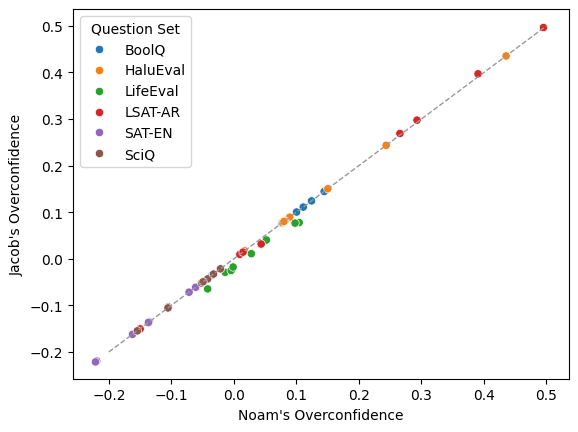

In [21]:
j['qset'] = j['qset'].cat.rename_categories({"LSAT": "LSAT-AR", "SAT": "SAT-EN"})

j['name'] = j['qset'].astype(str) + j['llm'].astype(str) 
d['name'] = d['Question Set'] + d['Model']

merged = pd.merge(d,j , on = "name", suffixes= ['_noam', '_jacob'])
merged['diff'] = merged['Overconfidence'] - merged['overconfidence']

display(merged[abs(merged['diff']) > 0.01]) # These are all the instances where Jacob and I disagree (some very small differences exist due to FPA)

ax = sns.scatterplot(data = merged, x ="Overconfidence", y = "overconfidence", hue = "Question Set")
plt.xlabel("Noam's Overconfidence")
plt.ylabel("Jacob's Overconfidence")
lo = -0.2
hi = 0.5
ax.plot([lo, hi], [lo, hi], ls="--", c="0.6", lw=1) 
plt.show()


---
## ECE Plots


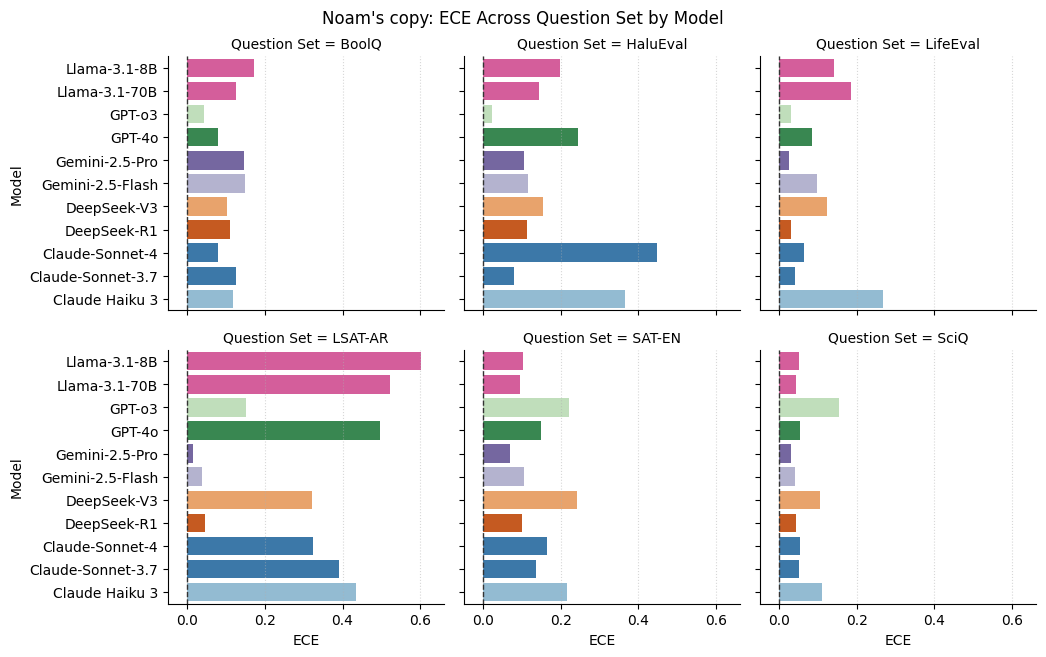

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# df has columns: "Question Set", "Model", "Overconfidence"
d = sum_df.copy()#.sort_values("Model", ascending = True)
model_order = ['Llama-3.1-8B', # Same order as Jacob
 'Llama-3.1-70B',
 'GPT-o3',
 'GPT-4o',
 'Gemini-2.5-Pro',
 'Gemini-2.5-Flash',
 'DeepSeek-V3',
 'DeepSeek-R1',
 'Claude-Sonnet-4',
 'Claude-Sonnet-3.7',
 'Claude Haiku 3'] 

palette = {m: pick_color(m) for m in sorted(d["Model"].unique(), key=str.lower)}

g = sns.catplot(
    data=d, kind="bar",
    x="ECE", y="Model",
    col="Question Set", col_wrap=3,
    order=model_order, hue = "Model",
    palette = palette,
    height=3.2, aspect=1.1,# edgecolor="0.0"
)

xmin = min(-0.05, d["ECE"].min()*1.1)
xmax = max( 0.05, d["ECE"].max()*1.1)
g.set(xlim=(xmin, xmax), xlabel="ECE", ylabel="Model")

for ax in g.axes.flat:
    ax.axvline(0, linestyle="--", linewidth=1, color="0.2")
    ax.grid(True, axis="x", linestyle=":", alpha=0.5)

plt.tight_layout()
g.figure.suptitle("Noam's copy: ECE Across Question Set by Model", y = 1.02)
plt.show()

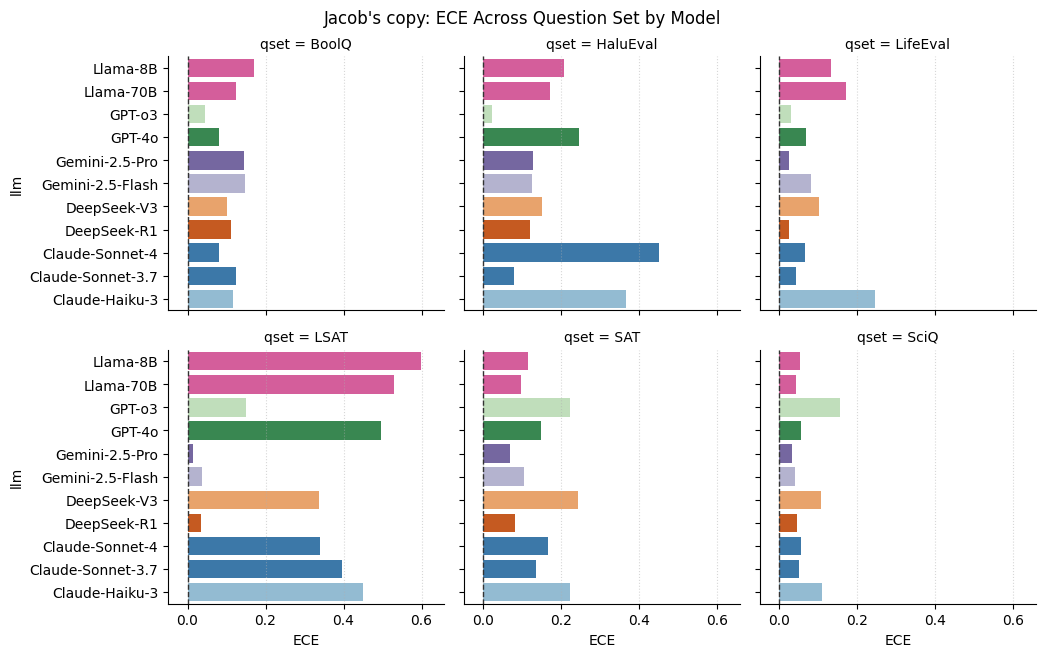

In [23]:
##
## Jacob's Version:

j = pd.read_csv(r"table1-info.csv")

qset_order = ["BoolQ", "HaluEval", "LifeEval", "LSAT", "SAT", "SciQ"]  # edit as needed
j["qset"] = pd.Categorical(j["qset"], categories=qset_order, ordered=True)

model_order = ['Llama-8B', # Same order as Jacob
 'Llama-70B',
 'GPT-o3',
 'GPT-4o',
 'Gemini-2.5-Pro',
 'Gemini-2.5-Flash',
 'DeepSeek-V3',
 'DeepSeek-R1',
 'Claude-Sonnet-4',
 'Claude-Sonnet-3.7',
 'Claude-Haiku-3'] 

palette = {m: pick_color(m) for m in sorted(j["llm"].unique(), key=str.lower)}

g = sns.catplot(
    data=j, kind="bar",
    x="ece", y="llm",
    col="qset", col_wrap=3,
    order=model_order, hue = "llm",
    palette = palette,
    height=3.2, aspect=1.1,# edgecolor="0.0"
)

xmin = min(-0.05, j["ece"].min()*1.1)
xmax = max( 0.05, j["ece"].max()*1.1)
g.set(xlim=(xmin, xmax), xlabel="ECE", ylabel="llm")

for ax in g.axes.flat:
    ax.axvline(0, linestyle="--", linewidth=1, color="0.2")
    ax.grid(True, axis="x", linestyle=":", alpha=0.5)

plt.tight_layout()
g.fig.suptitle("Jacob's copy: ECE Across Question Set by Model", y = 1.02)
plt.show()

Lets see how well they line up like before:

,Question Set,Model,Accuracy,ECE,Confidence,Overconfidence,name,qset,llm,num_tot,ece,accuracy,confidence,avg_gini,overconfidence,diff
12,HaluEval,Gemini-2.5-Flash,0.521229,0.114547,0.602872,0.081642,HaluEvalGemini-2.5-Flash,HaluEval,Gemini-2.5-Flash,1790,0.125721,0.521229,0.602872,NaN,0.081642,-0.011173
13,HaluEval,Gemini-2.5-Pro,0.521229,0.105503,0.601369,0.080140,HaluEvalGemini-2.5-Pro,HaluEval,Gemini-2.5-Pro,1790,0.126732,0.521229,0.601369,NaN,0.080140,-0.021229
19,LifeEval,DeepSeek-V3,0.532636,0.124056,0.637217,0.104581,LifeEvalDeepSeek-V3,LifeEval,DeepSeek-V3,751,0.102203,0.559457,0.637217,NaN,0.077760,0.021853
20,LifeEval,Gemini-2.5-Flash,0.537868,0.097951,0.635820,0.097951,LifeEvalGemini-2.5-Flash,LifeEval,Gemini-2.5-Flash,751,0.079789,0.559134,0.635820,NaN,0.076686,0.018162
22,LifeEval,GPT-4o,0.545491,0.085002,0.597670,0.052178,LifeEvalGPT-4o,LifeEval,GPT-4o,751,0.068043,0.557286,0.597670,NaN,0.040384,0.016959
25,LSAT-AR,Claude-Sonnet-4,0.453488,0.325000,0.719186,0.265698,LSAT-ARClaude-Sonnet-4,LSAT-AR,Claude-Sonnet-4,87,0.339144,0.448276,0.717305,0.383032,0.269029,-0.014144
26,LSAT-AR,DeepSeek-R1,0.953488,0.046047,0.997209,0.043721,LSAT-ARDeepSeek-R1,LSAT-AR,DeepSeek-R1,87,0.034023,0.965517,0.997241,0.005277,0.031724,0.012024
27,LSAT-AR,DeepSeek-V3,0.348837,0.320930,0.641860,0.293023,LSAT-ARDeepSeek-V3,LSAT-AR,DeepSeek-V3,87,0.336782,0.344828,0.642529,0.465546,0.297701,-0.015851
34,SAT-EN,DeepSeek-R1,0.942197,0.100058,0.870578,-0.071618,SAT-ENDeepSeek-R1,SAT-EN,DeepSeek-R1,173,0.081445,0.942197,0.870578,0.222920,-0.071618,0.018613


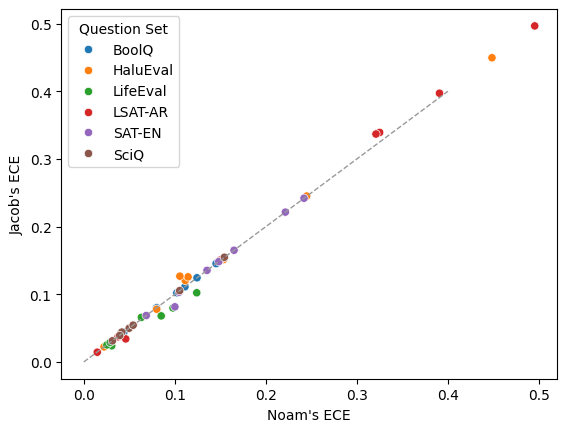

In [24]:
j['qset'] = j['qset'].cat.rename_categories({"LSAT": "LSAT-AR", "SAT": "SAT-EN"})

j['name'] = j['qset'].astype(str) + j['llm'].astype(str) 
d['name'] = d['Question Set'] + d['Model']

merged = pd.merge(d,j ,on = "name", suffixes= ['_noam', '_jacob'])
merged['diff'] = merged['ECE'] - merged['ece']

display(merged[abs(merged['diff']) > 0.01]) # These are all the instances where Jacob and I disagree (some very small differences exist due to FPA)

ax = sns.scatterplot(data = merged, x ="ECE", y = "ece", hue = "Question Set")
plt.xlabel("Noam's ECE")
plt.ylabel("Jacob's ECE")
lo = 0.0
hi = 0.4
ax.plot([lo, hi], [lo, hi], ls="--", c="0.6", lw=1) 
plt.show()


In [25]:
(combined_clean["Answer"] == "E").sum()

np.int64(156)

In [26]:
combined_clean["Answer"].value_counts().head(10)

Answer
True     13064
False    11966
D         3654
A         3650
B         3206
C         3128
True      1283
False     1220
85         859
81         727
Name: count, dtype: int64

Although we have the same average confidence and accuracy for HaluEval, we differ on ECE scores. I wonder why?

I always inlcude the lowest value (e.g. [0.1, 0.2)

It seems that Jacob uses `confidence_bin = cut(stated_confidence, breaks = 10)` in order to slice up the bins. I think in my implementation I added an additional bin for [1.0] leading to 11 bins while Jacob has 10. This may be the reason for differing results when looking at ECE.

## Calibration Plots **TODO**

Still have to fix this.

In [27]:
n  = 10

t = pd.Series([0.0, 0.15, 0.1, 0.3,0.8999,0.9, 0.99,1.0])
bins = np.linspace(0, 1, n+1)
bins

pd.cut(t, bins = bins)

0           NaN
1    (0.1, 0.2]
2    (0.0, 0.1]
3    (0.2, 0.3]
4    (0.8, 0.9]
5    (0.8, 0.9]
6    (0.9, 1.0]
7    (0.9, 1.0]
dtype: category
Categories (10, interval[float64, right]): [(0.0, 0.1] < (0.1, 0.2] < (0.2, 0.3] < (0.3, 0.4] ... (0.6, 0.7] < (0.7, 0.8] < (0.8, 0.9] < (0.9, 1.0]]

In [28]:
def melt_series(score, confidence):
    df = pd.DataFrame({'confidence': confidence, 'score': score})
    df = add_confidence_bin(df)
    df['score'] = df['score'].astype('float')
    # Group by confidence and aggregate
    melt_df = df.groupby('bin', observed=False).agg(
        mean_score=('score', 'mean'),
        count=('score', 'size'),
        mean_confidence = ('confidence', 'mean')
    ).reset_index()


    return melt_df


def add_confidence_bin(df: pd.DataFrame, col: str = 'confidence') -> pd.DataFrame:
    # Copy to avoid modifying original
    df = df.copy()

    # Clip confidence to [0, 1]
    df[col] = df[col].clip(0, 1)

    # Define bin edges and labels for 10 equal-width bins
    bins = np.linspace(0, 1, 11)        # edges: 0.0, 0.1, ..., 1.0 (11 edges -> 10 bins)
    # Labels correspond to the right-edge of each bin (0.1, 0.2, ..., 1.0)
    labels = [round(x, 1) for x in bins[1:]]

    # Assign bin label
    df['bin'] = pd.cut(
        df[col],
        bins=bins,
        labels=labels,
        ordered=False,
        right=True,   # include the right edge in the bin
        include_lowest=True
    )

    return df


def calibration_plot(
        scores: pd.Series, 
        confidence: pd.Series, 
        n_bins: int = 10,
        model_name: str = '',
        qset_name: str = '',
        num_complete: int = None,
        title: str = None,
        ax=None
        ):
    # Ensure inputs are numpy arrays / pandas series
    scores = pd.Series(scores).astype(float)
    confidence = pd.Series(confidence).astype(float)

    # If there's no data, draw an empty frame with a short title and return
# If there's no data, draw an empty frame with a short title and return
    if scores.dropna().size == 0 or confidence.dropna().size == 0:
        if ax is None:
            # ax = plt.gca() # <-- OLD
            fig, ax = plt.subplots() # <-- CHANGED: Create a new figure/axes
        ax.set_xlim(0, 1.1)
        ax.set_ylim(0, 1.1)
        ax.set_xlabel('Stated Confidence')
        ax.set_ylabel('Average Accuracy', labelpad=15)
        ax.set_title(f'Model = {model_name}\nQuestion Set = {qset_name}\n(n={num_complete})')
        # return # <-- OLD (implicitly returned None)
        return ax # <-- CHANGED: Return the new ax for consistency

    # Calculate ECE and Accuracy
    ece = get_ece(scores, confidence, n_bins=n_bins)
    acc = np.mean(scores.dropna())

    melted = melt_series(score=scores, confidence=confidence)

    # store into melted_dict if available
    try:
        melted_dict[qset_name][model_name] = melted
    except Exception:
        # if melted_dict isn't defined in caller's scope, skip storing
        pass

    # Use provided axes (for FacetGrid) or current axes
    if ax is None:
        ax = plt.gca()

    # 45-degree reference line
    ax.plot([0, 1.1], [0, 1.1], linestyle='--', color='grey')

    # Histogram (small bars showing proportion of responses in each bin)
    total = melted['count'].sum() if melted['count'].sum() > 0 else 1
    prop_vals = melted['count'].fillna(0) / total
    ax.bar(
        melted['mean_confidence'].fillna(0),
        prop_vals,
        width=0.025,
        align='center',
        edgecolor='white',
        color='orange',
        alpha=0.6
    )

    # Scatter of mean_confidence vs mean_score
    ax.scatter(melted['mean_confidence'], melted['mean_score'], color='blue')

    # Error Bars: Standard error for a proportion
    stderr = np.sqrt((melted['mean_score'] * (1 - melted['mean_score'])) / melted['count'])
    stderr = stderr.fillna(0)
    ax.errorbar(
        melted['mean_confidence'],
        melted['mean_score'],
        yerr=stderr,
        fmt='o',
        ecolor='grey',
        capsize=3,
    )

    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel('Stated Confidence')
    ax.set_ylabel('Average Accuracy', labelpad=15)
    if title is not None:
        ax.set_title(f'{title}\nECE: {ece:.3f} | Accuracy: {acc:.3f} | n = {num_complete}')
    else:
        ax.set_title(f'Calibration Plot for {model_name} on {qset_name}\nECE: {ece:.3f} | Accuracy: {acc:.3f} | n = {num_complete}')
    ticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    ax.set_xticks(ticks)

    # Create/attach a secondary y-axis for proportion (avoid creating multiple if re-used)
    ax2 = getattr(ax, '_calib_ax2', None)
    if ax2 is None:
        ax2 = ax.twinx()
        setattr(ax, '_calib_ax2', ax2)

    ax2.set_ylabel('Proportion of Stated Confidence', rotation=-90, labelpad=15)
    ax2.set_ylim(0, 1.1)
    ax.set_ylim(0, 1.1)

    return ax


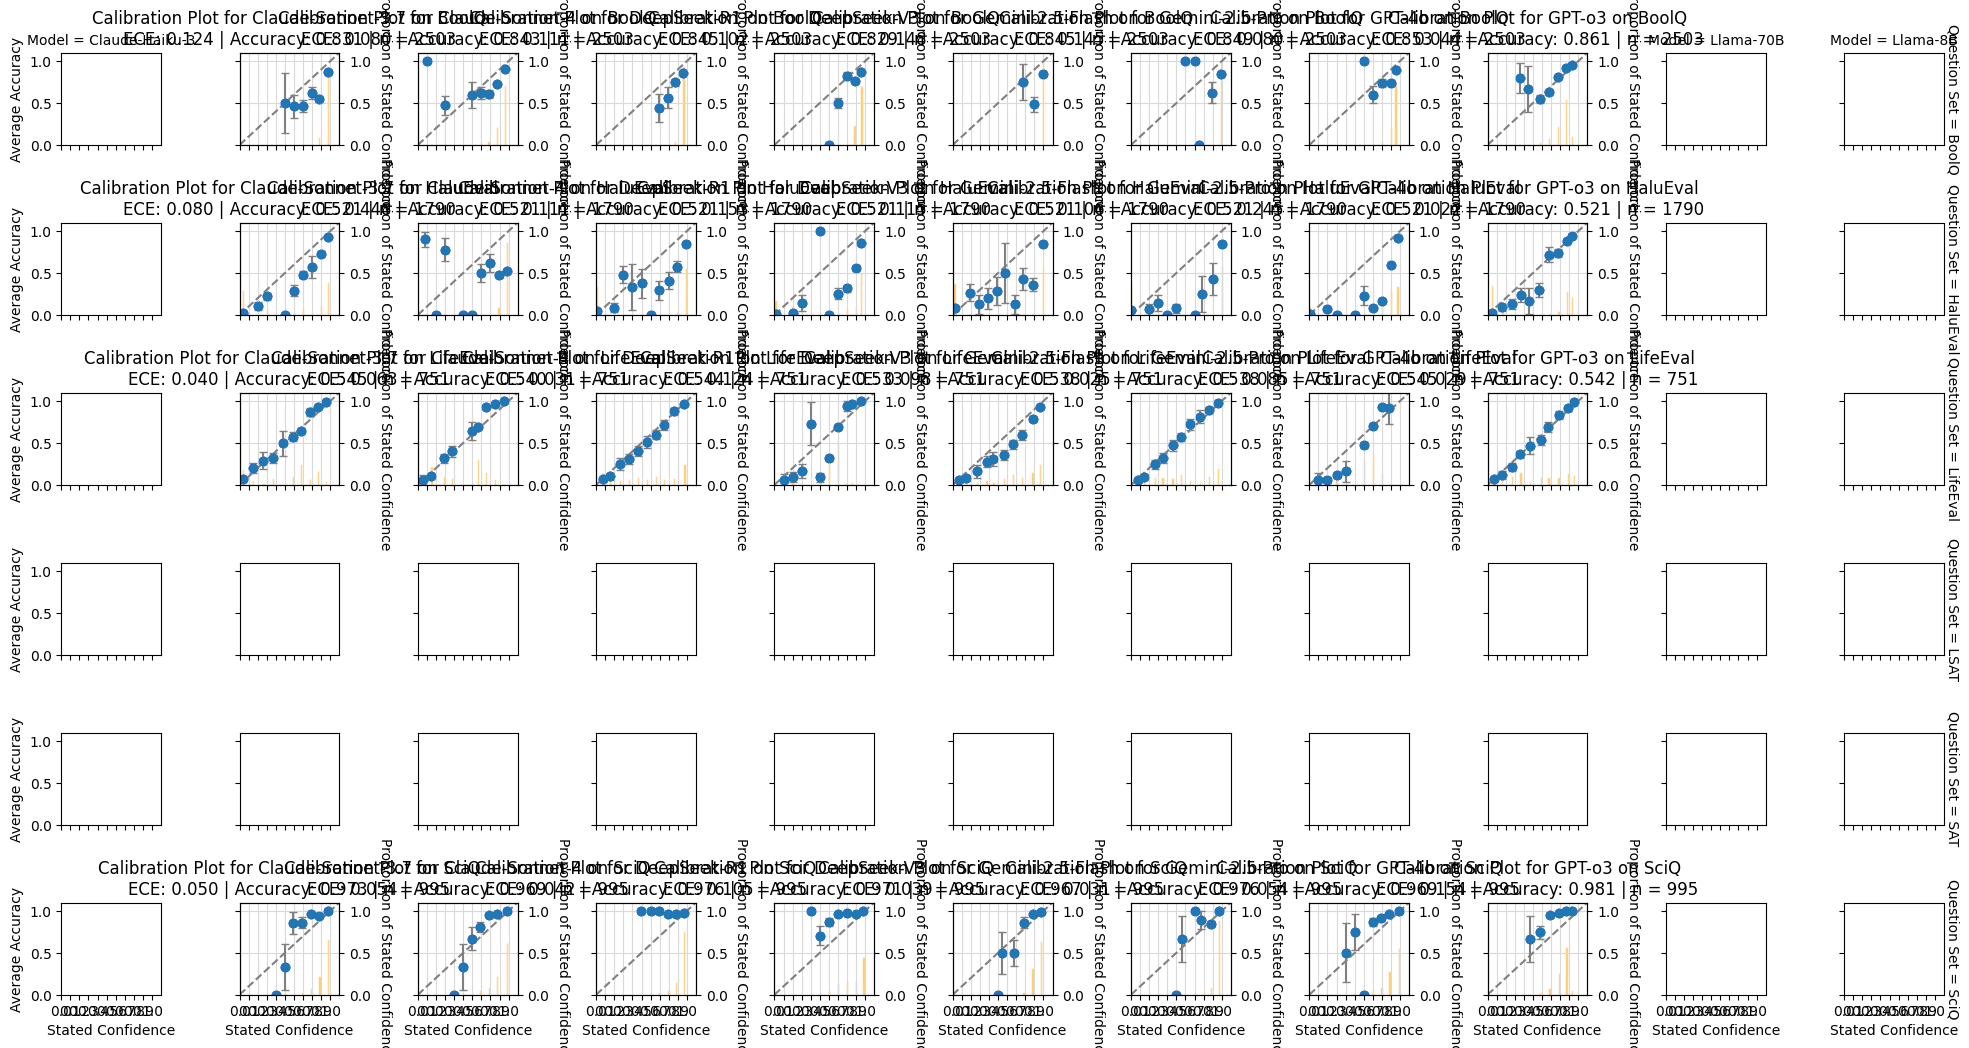

In [29]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt

# df columns: qset, llm, score, confidence
d = combined_clean.copy()

# optional fixed order
model_order = ['Claude-Haiku-3','Claude-Sonnet-3.7','Claude-Sonnet-4',
               'DeepSeek-R1','DeepSeek-V3','Gemini-2.5-Flash','Gemini-2.5-Pro',
               'GPT-4o','GPT-o3','Llama-70B','Llama-8B']
qset_order  = ['BoolQ','HaluEval','LifeEval','LSAT','SAT','SciQ']
d["Model"]  = pd.Categorical(d["Model"],  categories=model_order, ordered=True)
d["Question Set"] = pd.Categorical(d["Question Set"], categories=qset_order,  ordered=True)

g = sns.FacetGrid(d, row="Question Set", col="Model",
                  margin_titles=True, sharex=True, sharey=True,
                  despine=False, height=1.8, aspect=1.0)

from collections import defaultdict
melted_dict = defaultdict(dict)

def _panel(data, color, **kws):
    ax = plt.gca()
    model = data["Model"].iat[0]
    qset  = data["Question Set"].iat[0]

    # Choose the appropriate confidence column for MCQ vs others
    if qset in mcq_qsets:
        conf_col = "Stated Confidence Answer (MCQ)"
    else:
        conf_col = "Stated Confidence Answer"

    # Coerce score and confidence to numeric and keep only rows with both present
    scores = pd.to_numeric(data.get("Score", pd.Series(dtype=float)), errors='coerce')
    confid = pd.to_numeric(data.get(conf_col, pd.Series(dtype=float)), errors='coerce')

    mask = scores.notna() & confid.notna()

    # If there are no valid rows, call calibration_plot with empty series so it will render an empty frame
    if mask.sum() == 0:
        calibration_plot(scores=pd.Series([], dtype=float),
                         confidence=pd.Series([], dtype=float),
                         model_name=model,
                         qset_name=qset,
                         num_complete=0,
                         ax=ax)
    else:
        calibration_plot(scores=scores[mask],
                         confidence=confid[mask],
                         model_name=model,
                         qset_name=qset,
                         num_complete=mask.sum(),
                         ax=ax)

    ax.set_xlim(0,1.1); ax.set_ylim(0,1.1); ax.grid(True, color="0.85")


g.map_dataframe(_panel)
g.set_axis_labels("Stated Confidence", "Average Accuracy")
g.figure.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


# Pre-Registered Analysis

* For each model/question set combination we will compute ECE and overconfidence. We will test whether they differ from zero for each model and in aggregate.
* In addition, we will build  a calibration plot. The calibration plot will be designed as follows: Confidence (stated or token)  along the x-axis and accuracy on the y-axis. The analysis is at the level of the bin, which is to say for multiple-choice questions with 4 answer options, there will be 4 observations. Answer options are binned according to the probability assigned to them by the LLM. The 11 bins are: [0-10), [10-20), [20-30), [30-40), [40-50), [50-60), [60-70), [70-80), [80-90), [90-100), [100]
* For each of the 11 bins, we average the confidence of observations within it, and that determines where the dot is placed on the horizontal axis. We then average the accuracy of those responses (what percentage of the time is that answer option the right one?) and that accuracy determines the dot's location on the y-axis.

## ECE Plots

First we can look at how each model did on each question set individually:

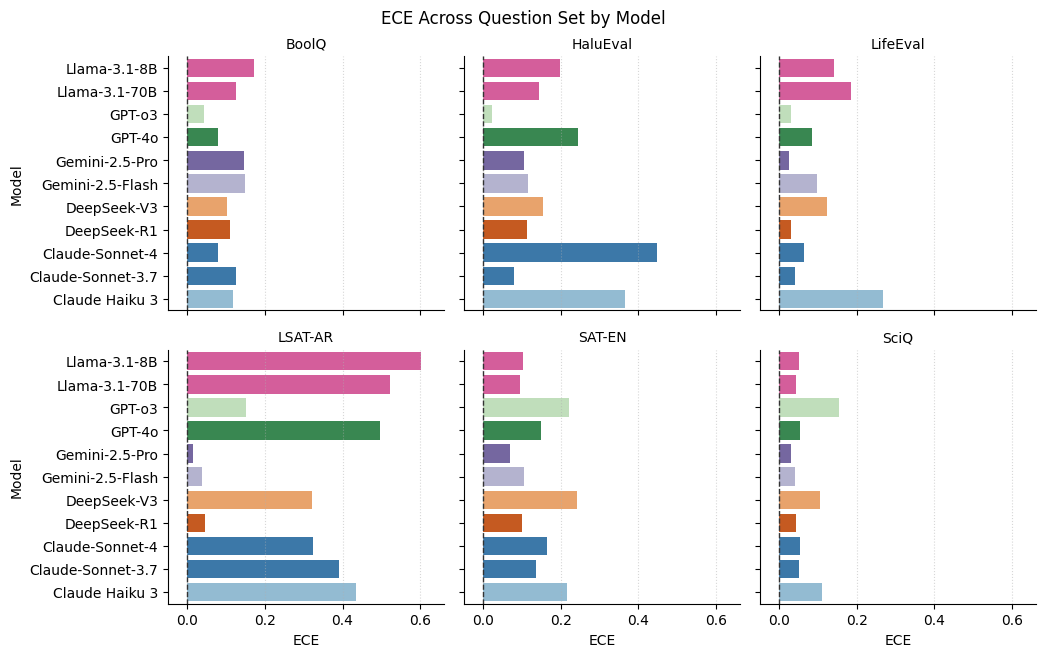

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# df has columns: "Question Set", "Model", "Overconfidence"
d = sum_df.copy()#.sort_values("Model", ascending = True)
model_order = ['Llama-3.1-8B', # Same order as Jacob
 'Llama-3.1-70B',
 'GPT-o3',
 'GPT-4o',
 'Gemini-2.5-Pro',
 'Gemini-2.5-Flash',
 'DeepSeek-V3',
 'DeepSeek-R1',
 'Claude-Sonnet-4',
 'Claude-Sonnet-3.7',
 'Claude Haiku 3'] 

palette = {m: pick_color(m) for m in sorted(d["Model"].unique(), key=str.lower)}

g = sns.catplot(
    data=d, kind="bar",
    x="ECE", y="Model",
    col="Question Set", col_wrap=3,
    order=model_order, hue = "Model",
    palette = palette,
    height=3.2, aspect=1.1,# edgecolor="0.0"
)

xmin = min(-0.05, d["ECE"].min()*1.1)
xmax = max( 0.05, d["ECE"].max()*1.1)
g.set(xlim=(xmin, xmax), xlabel="ECE", ylabel="Model")

g.set_titles(col_template="{col_name}")

for ax in g.axes.flat:
    ax.axvline(0, linestyle="--", linewidth=1, color="0.2")
    ax.grid(True, axis="x", linestyle=":", alpha=0.5)

plt.tight_layout()
g.figure.suptitle("ECE Across Question Set by Model", y = 1.02)
plt.show()

Now, lets see how models did in agregate:

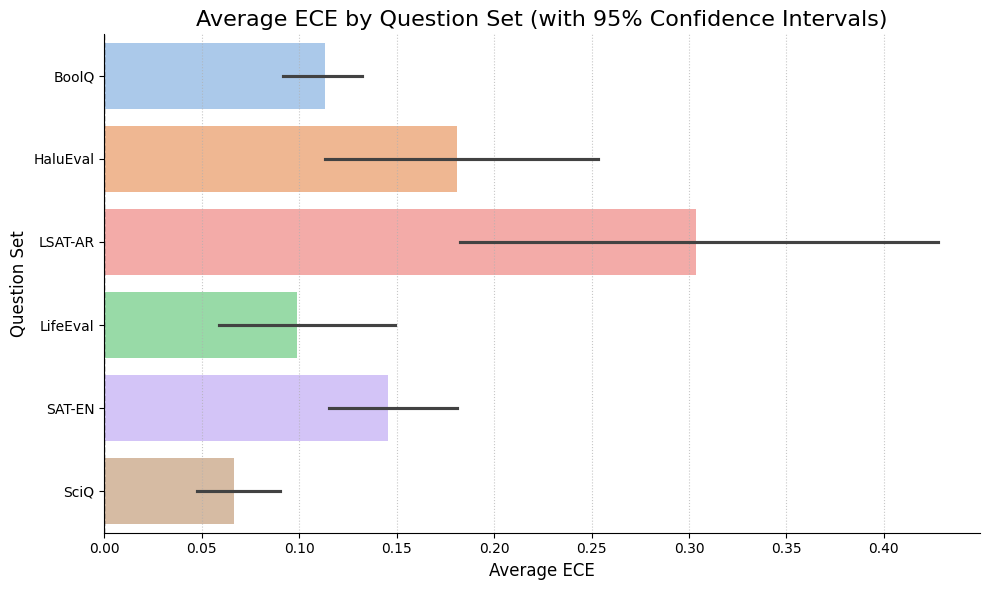

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'd' is your original DataFrame with ECE values 
# for each model and question set.

# 1. Determine the sorted order for the plot
# We do this by calculating the mean ECE for each set and sorting them,
# Doing so alphabetically
order_of_sets = d.groupby('Question Set')['Question Set'].unique().sort_values(ascending=True).index

# 2. Create the plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=d,             # *** Pass the original DataFrame 'd' ***
    x='ECE',
    y='Question Set',
    hue = "Question Set",
    order=order_of_sets, # Apply the sorted order
    palette='pastel'
    # Seaborn automatically calculates the mean and 95% confidence
    # interval (the error bars) when you pass the full data.
)

# Set labels and title
ax.set_title('Average ECE by Question Set (with 95% Confidence Intervals)', fontsize=16)
ax.set_xlabel('Average ECE', fontsize=12)
ax.set_ylabel('Question Set', fontsize=12)

# Add gridlines and clean up spines, similar to your original plot
ax.grid(True, axis='x', linestyle=':', alpha=0.7)
ax.axvline(0, linestyle="--", linewidth=1, color="0.2") # Add the zero line
ax.spines[['right', 'top']].set_visible(False)

plt.tight_layout()
plt.show()

## Overconfidence Plots

Like before, we can first compare how overconfident models were individually.

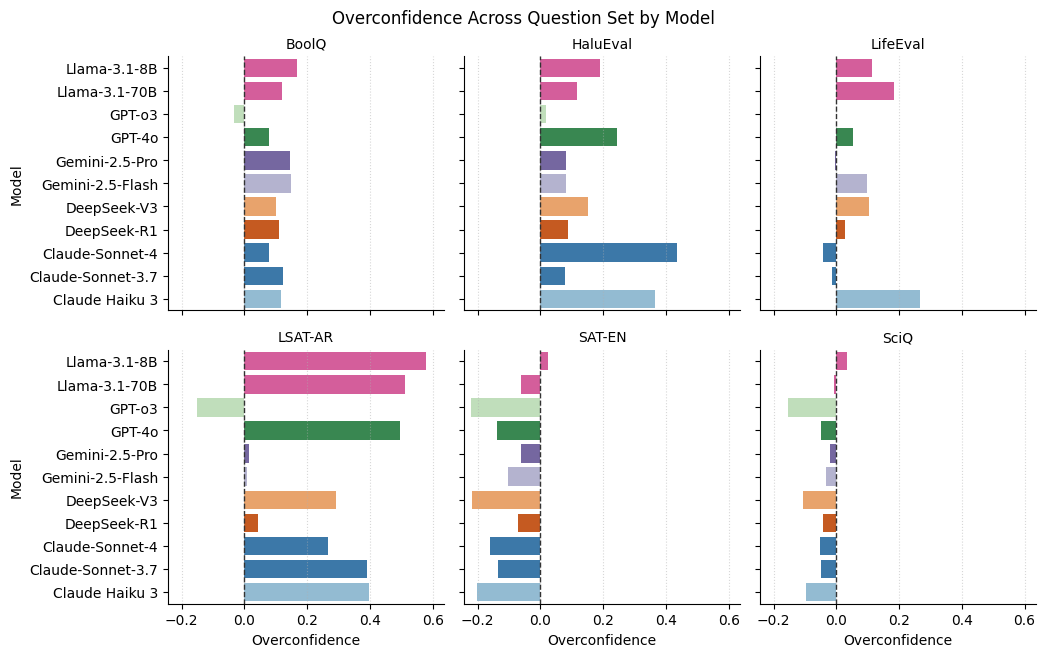

In [32]:
# df has columns: "Question Set", "Model", "Overconfidence"
d = sum_df.copy()#.sort_values("Model", ascending = True)
model_order = ['Llama-3.1-8B', # Same order as Jacob
 'Llama-3.1-70B',
 'GPT-o3',
 'GPT-4o',
 'Gemini-2.5-Pro',
 'Gemini-2.5-Flash',
 'DeepSeek-V3',
 'DeepSeek-R1',
 'Claude-Sonnet-4',
 'Claude-Sonnet-3.7',
 'Claude Haiku 3'] 

palette = {m: pick_color(m) for m in sorted(d["Model"].unique(), key=str.lower)}

g = sns.catplot(
    data=d, kind="bar",
    x="Overconfidence", y="Model",
    col="Question Set", col_wrap=3,
    order=model_order, hue = "Model",
    palette = palette,
    height=3.2, aspect=1.1,# edgecolor="0.0"
)

xmin = min(-0.05, d["Overconfidence"].min()*1.1)
xmax = max( 0.05, d["Overconfidence"].max()*1.1)
g.set(xlim=(xmin, xmax), xlabel="Overconfidence", ylabel="Model")
g.set_titles(col_template="{col_name}")


for ax in g.axes.flat:
    ax.axvline(0, linestyle="--", linewidth=1, color="0.2")
    ax.grid(True, axis="x", linestyle=":", alpha=0.5)

plt.tight_layout()
g.figure.suptitle("Overconfidence Across Question Set by Model", y = 1.02)
plt.show()


And again, lets see how models did in agregate:


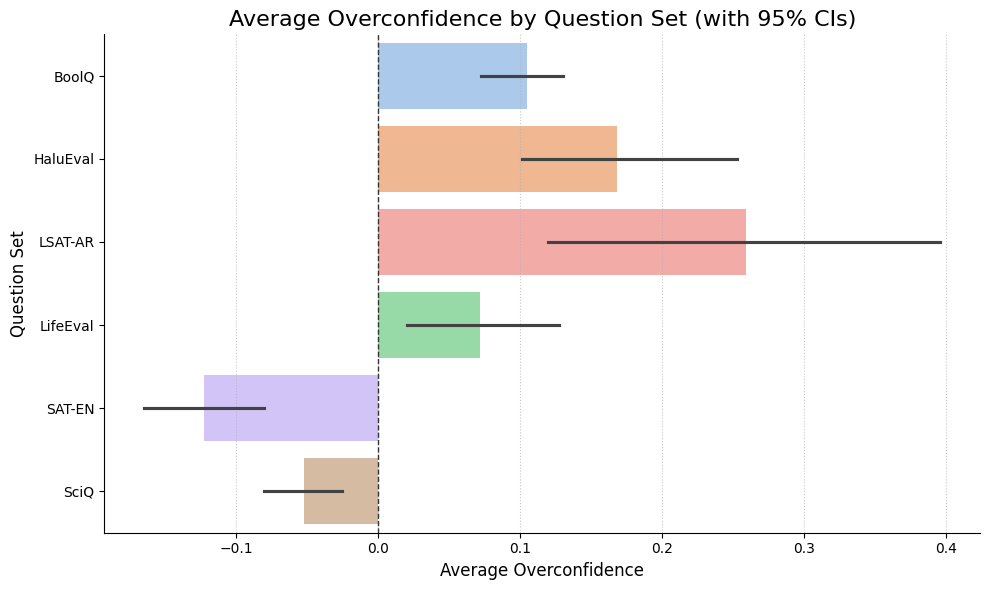

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'd' is your DataFrame with "Overconfidence", "Model", 
# and "Question Set" columns.

# 1. Determine the sorted order for the plot
# We sort by the mean overconfidence for each question set.
overconfidence_order = d.groupby('Question Set')['Overconfidence'].mean().sort_values(ascending=False).index
order_of_sets = d.groupby('Question Set')['Question Set'].unique().sort_values(ascending=True).index

# 2. Create the plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=d,                  # *** Pass the original DataFrame 'd' ***
    x='Overconfidence',      # *** Plot the 'Overconfidence' column ***
    y='Question Set',
    order=order_of_sets, # Apply the sorted order
    hue = "Question Set",
    palette='pastel'         # Switched palette for variety (cool colors)
)

# Set labels and title
ax.set_title('Average Overconfidence by Question Set (with 95% CIs)', fontsize=16)
ax.set_xlabel('Average Overconfidence', fontsize=12)
ax.set_ylabel('Question Set', fontsize=12)

# Add gridlines and clean up spines
ax.grid(True, axis='x', linestyle=':', alpha=0.7)
ax.axvline(0, linestyle="--", linewidth=1, color="0.2") # Add the zero line
ax.spines[['right', 'top']].set_visible(False)

plt.tight_layout()
plt.show()

## Accuracy Plots

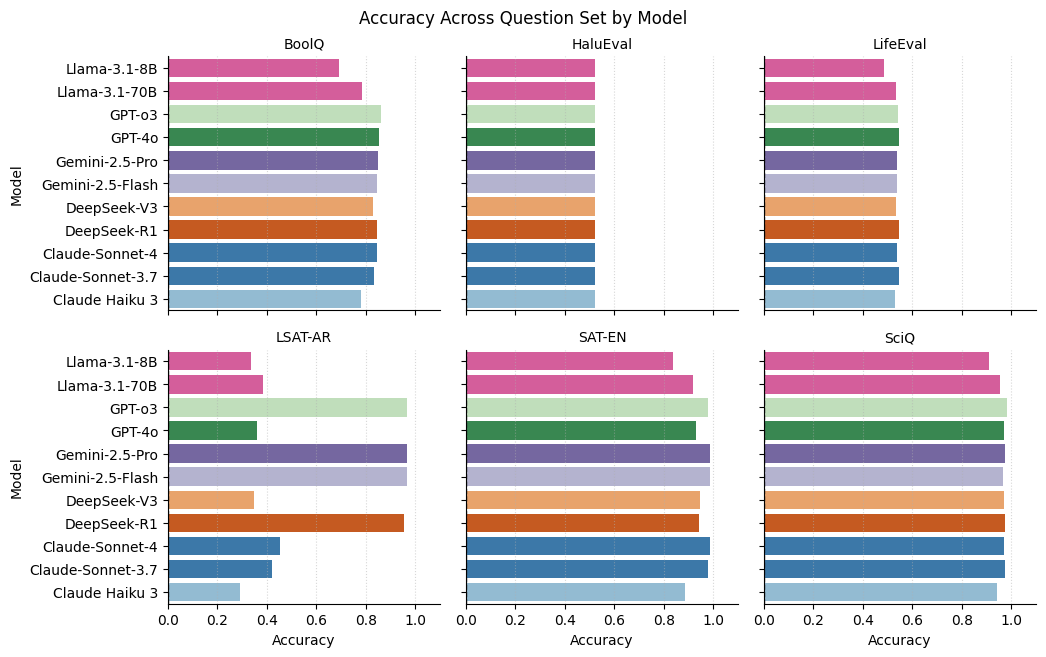

In [183]:
# df has columns: "Question Set", "Model", "Overconfidence"
d = sum_df.copy()#.sort_values("Model", ascending = True)
model_order = ['Llama-3.1-8B', # Same order as Jacob
 'Llama-3.1-70B',
 'GPT-o3',
 'GPT-4o',
 'Gemini-2.5-Pro',
 'Gemini-2.5-Flash',
 'DeepSeek-V3',
 'DeepSeek-R1',
 'Claude-Sonnet-4',
 'Claude-Sonnet-3.7',
 'Claude Haiku 3'] 

palette = {m: pick_color(m) for m in sorted(d["Model"].unique(), key=str.lower)}

g = sns.catplot(
    data=d, kind="bar",
    x="Accuracy", y="Model",
    col="Question Set", col_wrap=3,
    order=model_order, hue = "Model",
    palette = palette,
    height=3.2, aspect=1.1,# edgecolor="0.0"
)

xmin = 0
xmax = 1.1
g.set(xlim=(xmin, xmax), xlabel="Accuracy", ylabel="Model")
g.set_titles(col_template="{col_name}")


for ax in g.axes.flat:
    ax.axvline(0, linestyle="--", linewidth=1, color="0.2")
    ax.grid(True, axis="x", linestyle=":", alpha=0.5)

plt.tight_layout()
g.figure.suptitle("Accuracy Across Question Set by Model", y = 1.02)
plt.show()


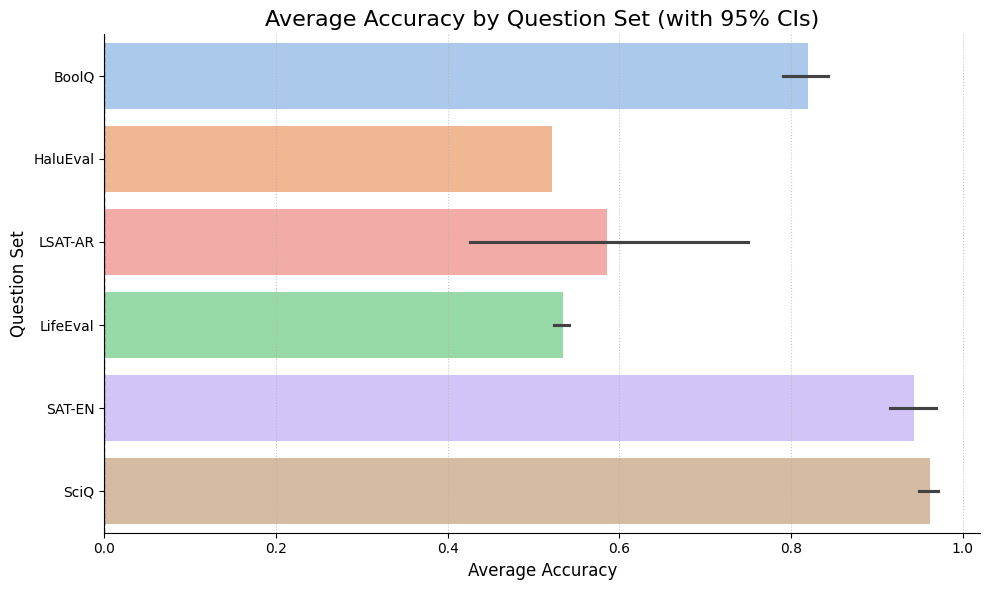

In [182]:


# 1. Determine the sorted order for the plot
# We sort by the mean overconfidence for each question set.
overconfidence_order = d.groupby('Question Set')['Accuracy'].mean().sort_values(ascending=False).index
order_of_sets = d.groupby('Question Set')['Question Set'].unique().sort_values(ascending=True).index

# 2. Create the plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=d,                  # *** Pass the original DataFrame 'd' ***
    x='Accuracy',      # *** Plot the 'Overconfidence' column ***
    y='Question Set',
    order=order_of_sets, # Apply the sorted order
    hue = "Question Set",
    palette='pastel'         # Switched palette for variety (cool colors)
)

# Set labels and title
ax.set_title('Average Accuracy by Question Set (with 95% CIs)', fontsize=16)
ax.set_xlabel('Average Accuracy', fontsize=12)
ax.set_ylabel('Question Set', fontsize=12)

# Add gridlines and clean up spines
ax.grid(True, axis='x', linestyle=':', alpha=0.7)
ax.axvline(0, linestyle="--", linewidth=1, color="0.2") # Add the zero line
ax.spines[['right', 'top']].set_visible(False)

plt.tight_layout()
plt.show()

## Look at the reasoning

NameError: name 'left' is not defined

## Calibration Plots

Individual Calibration plots can be found in the `Plots` folder. We want to see how models did in agregate.

In [34]:
def melt_series(score, confidence):
    df = pd.DataFrame({'confidence': confidence, 'score': score})
    df = add_confidence_bin(df)
    df['score'] = df['score'].astype('float')
    # Group by confidence and aggregate
    melt_df = df.groupby('bin', observed=False).agg(
        mean_score=('score', 'mean'),
        count=('score', 'size'),
        mean_confidence = ('confidence', 'mean')
    ).reset_index()


    return melt_df


def add_confidence_bin(df: pd.DataFrame, col: str = 'confidence') -> pd.DataFrame:
    # Copy to avoid modifying original
    df = df.copy()

    # Clip confidence to [0, 1]
    df[col] = df[col].clip(0, 1)

    # Define bin edges and labels for 10 equal-width bins
    bins = np.linspace(0, 1, 11)        # edges: 0.0, 0.1, ..., 1.0 (11 edges -> 10 bins)
    # Labels correspond to the right-edge of each bin (0.1, 0.2, ..., 1.0)
    labels = [round(x, 1) for x in bins[1:]]

    # Assign bin label
    df['bin'] = pd.cut(
        df[col],
        bins=bins,
        labels=labels,
        ordered=False,
        right=False,   # include the right edge in the bin
        include_lowest=True
    )

    return df


def calibration_plot(
        scores: pd.Series, 
        confidence: pd.Series, 
        n_bins: int = 10,
        model_name: str = '',
        qset_name: str = '',
        num_complete: int = None,
        title: str = None,
        ax=None
        ):
    # Ensure inputs are numpy arrays / pandas series
    scores = pd.Series(scores).astype(float)
    confidence = pd.Series(confidence).astype(float)

    # If there's no data, draw an empty frame with a short title and return
    # If there's no data, draw an empty frame with a short title and return
    if scores.dropna().size == 0 or confidence.dropna().size == 0:
        if ax is None:
            # ax = plt.gca() # <-- OLD
            fig, ax = plt.subplots() # <-- CHANGED: Create a new figure/axes
        ax.set_xlim(0, 1.1)
        ax.set_ylim(0, 1.1)
        ax.set_xlabel('Stated Confidence')
        ax.set_ylabel('Average Accuracy', labelpad=15)
        ax.set_title(f'Model = {model_name}\nQuestion Set = {qset_name}\n(n={num_complete})')
        # return # <-- OLD (implicitly returned None)
        return ax # <-- CHANGED: Return the new ax for consistency

    # Calculate ECE and Accuracy
    ece = get_ece(scores, confidence, n_bins=n_bins)
    acc = np.mean(scores.dropna())

    melted = melt_series(score=scores, confidence=confidence)

    # store into melted_dict if available
    try:
        melted_dict[qset_name][model_name] = melted
    except Exception:
        # if melted_dict isn't defined in caller's scope, skip storing
        pass

    # Use provided axes (for FacetGrid) or current axes
    if ax is None:
        ax = plt.gca()

    # 45-degree reference line
    ax.plot([0, 1.1], [0, 1.1], linestyle='--', color='grey')

    # Histogram (small bars showing proportion of responses in each bin)
    total = melted['count'].sum() if melted['count'].sum() > 0 else 1
    prop_vals = melted['count'].fillna(0) / total
    ax.bar(
        melted['mean_confidence'].fillna(0),
        prop_vals,
        width=0.025,
        align='center',
        edgecolor='white',
        color='orange',
        alpha=0.6
    )

    # Scatter of mean_confidence vs mean_score
    ax.scatter(melted['mean_confidence'], melted['mean_score'], color='blue')

    # Error Bars: Standard error for a proportion
    stderr = np.sqrt((melted['mean_score'] * (1 - melted['mean_score'])) / melted['count'])
    stderr = stderr.fillna(0)
    ax.errorbar(
        melted['mean_confidence'],
        melted['mean_score'],
        yerr=stderr,
        fmt='o',
        ecolor='grey',
        capsize=3,
    )

    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel('Stated Confidence')
    ax.set_ylabel('Average Accuracy', labelpad=15)
    if title is not None:
        ax.set_title(f'{title}\nECE: {ece:.3f} | Accuracy: {acc:.3f} | n = {num_complete}')
    else:
        ax.set_title(f'Calibration Plot for {model_name} on {qset_name}\nECE: {ece:.3f} | Accuracy: {acc:.3f} | n = {num_complete}')
    ticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    ax.set_xticks(ticks)

    # Create/attach a secondary y-axis for proportion (avoid creating multiple if re-used)
    ax2 = getattr(ax, '_calib_ax2', None)
    if ax2 is None:
        ax2 = ax.twinx()
        setattr(ax, '_calib_ax2', ax2)

    ax2.set_ylabel('Proportion of Stated Confidence', rotation=-90, labelpad=15)
    ax2.set_ylim(0, 1.1)
    ax.set_ylim(0, 1.1)

    return ax


In [35]:


def expand_mcq(df):
    s = []
    c = []
    letters = ['A', 'B', 'C', 'D', 'E']

    # Using iterrows correctly now: 'row' is the Series data for the current row
    for index, row in df.iterrows(): 
        # --- 1. Handle the Model's Stated Answer ---
        stated_answer = row['Answer']
        stated_answer_confidence = row['Stated Confidence Answer (MCQ)']
        stated_answer_score = row['Score']

        s.append(stated_answer_score)
        c.append(stated_answer_confidence)
        
        # --- 2. Handle the Other (Unanswered) Options ---
        ca = row['Correct Answer']

        # FIX 1: Use list comprehension to get the remaining letters without modifying the original list
        not_answered_letters = [l for l in letters if l != stated_answer] 
        # NOTE: The original letters list is ['A', 'B', 'C', 'D', 'E'].
        # The Python list method .remove() modifies the list IN PLACE and returns None.
        # Your original line: letters.remove(stated_answer) assigned None to the variable.
        # This list comprehension creates a *new* list correctly.

        for l in not_answered_letters:
            # Score is 1 (True) or 0 (False)
            l_score = 1 if l == ca else 0 

            l_conf_col = f"Stated Confidence {l}"
            l_conf = row[l_conf_col]
            
            # Check for NaN/missing confidence (e.g., option 'E' in some 4-option questions)
            if pd.isna(l_conf): # Changed to pd.isna() for clarity/safety
                continue

            # FIX 2: Append the new confidence value (l_conf), not the list itself (c)
            s.append(l_score)
            c.append(l_conf) # <-- Corrected: Appending the single confidence value

    
    return s, c

def expand_tokens(df):
    s = []
    c = []
    answers = ['True', 'False', 'A', 'B', 'C', 'D', 'E']

    # Using iterrows correctly now: 'row' is the Series data for the current row
    for index, row in df.iterrows(): 
        # --- 1. Handle the Model's Stated Answer ---
        # stated_answer = row['Answer']
        # token_answer_confidence = row['Stated Confidence Answer (MCQ)']
        # stated_answer_score = row['Score']

        # s.append(stated_answer_score)
        # c.append(token_answer_confidence)
        
        # --- 2. Handle the Other (Unanswered) Options ---
        ca = row['Correct Answer']

        # NOTE: The original letters list is ['A', 'B', 'C', 'D', 'E'].
        # The Python list method .remove() modifies the list IN PLACE and returns None.
        # Your original line: letters.remove(stated_answer) assigned None to the variable.
        # This list comprehension creates a *new* list correctly.

        for l in answers:
            # Score is 1 (True) or 0 (False)
            l_score = 1 if l == ca else 0 

            l_conf_col = f"Token Probability {l}"
            l_conf = row[l_conf_col]
            
            # Check for NaN/missing confidence (e.g., option 'E' in some 4-option questions)
            if pd.isna(l_conf): # Changed to pd.isna() for clarity/safety
                continue

            # FIX 2: Append the new confidence value (l_conf), not the list itself (c)
            s.append(l_score)
            c.append(l_conf) # <-- Corrected: Appending the single confidence value

    return s, c


def melt_series(score, confidence):
    df = pd.DataFrame({'confidence': confidence, 'score': score})
    df = add_confidence_bin(df)
    df['score'] = df['score'].astype('float')
    # Group by confidence and aggregate
    melt_df = df.groupby('bin', observed=False).agg(
        mean_score=('score', 'mean'),
        count=('score', 'size'),
        mean_confidence = ('confidence', 'mean')
    ).reset_index()


    return melt_df


def add_confidence_bin(df: pd.DataFrame, col: str = 'confidence') -> pd.DataFrame:
    # Copy to avoid modifying original
    df = df.copy()

    # Clip confidence to [0, 1]
    df[col] = df[col].clip(0, 1)

    # Define bin edges and labels for 11 equal-width bins
    bins = np.linspace(0, 1, 11)        # edges: 0.0, 0.1, ..., 1.0 (11 edges -> 10 bins)
    # Labels correspond to the left-edge of each bin (0.1, 0.2, ..., 1.0)
    labels = [round(x, 1) for x in bins[0:]]

    # Assign bin label
    df['bin'] = pd.cut(
        df[col],
        bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.000001],
        labels=labels,
        ordered=False,
        right=False,   # include the right edge in the bin
        include_lowest=True
    )

    return df




def calibration_plot(
        scores: pd.Series, 
        confidence: pd.Series, 
        n_bins: int = 10,
        model_name: str = '',
        qset_name: str = '',
        num_complete: int = None,
        title: str = None,
        ax=None,
        x_label: str = "Stated Confidence",
        debug = False,
        save_fig_to: Path = None
        ):
    # Ensure inputs are numpy arrays / pandas series
    scores = pd.Series(scores).astype(float)
    confidence = pd.Series(confidence).astype(float)

    # If there's no data, draw an empty frame with a short title and return
    if scores.dropna().size == 0 or confidence.dropna().size == 0:
        if ax is None:
            # ax = plt.gca() # <-- OLD
            fig, ax = plt.subplots() # <-- CHANGED: Create a new figure/axes
        ax.set_xlim(0, 1.1)
        ax.set_ylim(0, 1.1)
        ax.set_xlabel(x_label)
        ax.set_ylabel('Average Accuracy', labelpad=15)
        ax.set_title(f'Model = {model_name}\nQuestion Set = {qset_name}\n(n={num_complete})')
        # return # <-- OLD (implicitly returned None)
        return ax # <-- CHANGED: Return the new ax for consistency

    # Calculate ECE and Accuracy
    ece = get_ece(scores, confidence, n_bins=n_bins) 
    acc = np.mean(scores.dropna())

    melted = melt_series(score=scores, confidence=confidence) 
    if debug:
        print('-'*64)
        print(title)
        display(melted)
        print('-'*64)

    # store into melted_dict if available
    try:
        melted_dict[qset_name][model_name] = melted 
    except Exception:
        # if melted_dict isn't defined in caller's scope, skip storing
        pass

    # Use provided axes (for FacetGrid) or current axes
    if ax is None:
        # ax = plt.gca() # <-- OLD
        fig, ax = plt.subplots() # <-- CHANGED: Create a new figure/axes

    # 45-degree reference line
    ax.plot([0, 1.1], [0, 1.1], linestyle='--', color='grey')

    # Histogram (small bars showing proportion of responses in each bin)
    total = melted['count'].sum() if melted['count'].sum() > 0 else 1
    prop_vals = melted['count'].fillna(0) / total
    ax.bar(
        melted['mean_confidence'].fillna(0),
        prop_vals,
        width=0.025,
        align='center',
        edgecolor='white',
        color='orange',
        alpha=0.6
    )

    # Scatter of mean_confidence vs mean_score
    ax.scatter(melted['mean_confidence'], melted['mean_score'], color='blue')

    # Error Bars: Standard error for a proportion
    stderr = np.sqrt((melted['mean_score'] * (1 - melted['mean_score'])) / melted['count'])
    stderr = stderr.fillna(0)
    ax.errorbar(
        melted['mean_confidence'],
        melted['mean_score'],
        yerr=stderr,
        fmt='o',
        ecolor='grey',
        capsize=3,
    )

    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel(x_label)
    ax.set_ylabel('Average Accuracy', labelpad=15)
    if title is not None:
        ax.set_title(f'{title}\nECE: {ece:.3f} | Accuracy: {acc:.3f} | n = {num_complete}')
    else:
        ax.set_title(f'Calibration Plot for {model_name} on {qset_name}\nECE: {ece:.3f} | Accuracy: {acc:.3f} | n = {num_complete}')
    ticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    ax.set_xticks(ticks)

    # Create/attach a secondary y-axis for proportion (avoid creating multiple if re-used)
    ax2 = getattr(ax, '_calib_ax2', None)
    if ax2 is None:
        ax2 = ax.twinx()
        setattr(ax, '_calib_ax2', ax2)
    new_y = 'Proportion of ' + x_label
    ax2.set_ylabel(new_y, rotation=-90, labelpad=15)
    ax2.set_ylim(0, 1.1)
    ax.set_ylim(0, 1.1)

    plt.show()

    if save_fig_to:
        new_file_name = title.lower().replace(" ", "_") + "_cal_plot.png"
        new_path = save_fig_to.joinpath(new_file_name)
        plt.savefig(new_path)

    return ax

### Stated Confidence

Would we have a class imbalance issue given BoolQ's size (2700) compared to other datasets like 

Multiple Choice Questions ['LSAT-AR', 'SAT-EN', 'SciQ']
    Subset Length: 1254.0


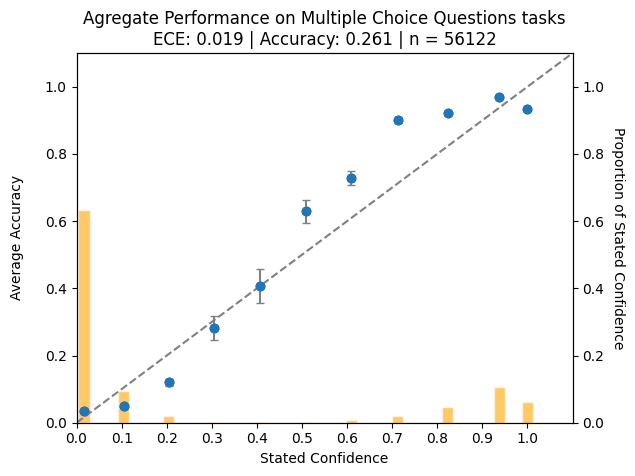

Factual ['BoolQ', 'HaluEval']
    Subset Length: 4293.0


<Figure size 640x480 with 0 Axes>

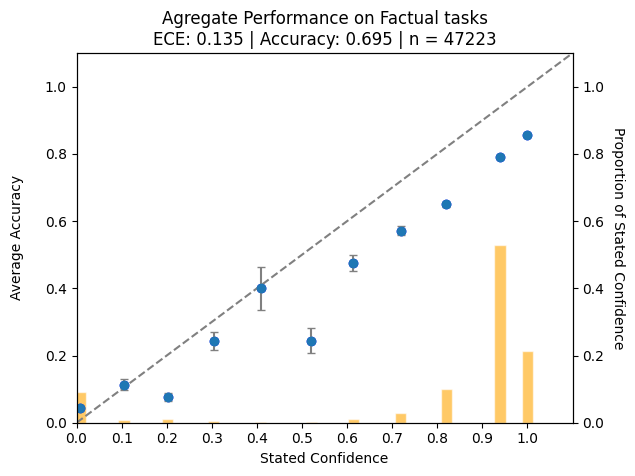

Probability Estimation ['LifeEval']
    Subset Length: 751.0


<Figure size 640x480 with 0 Axes>

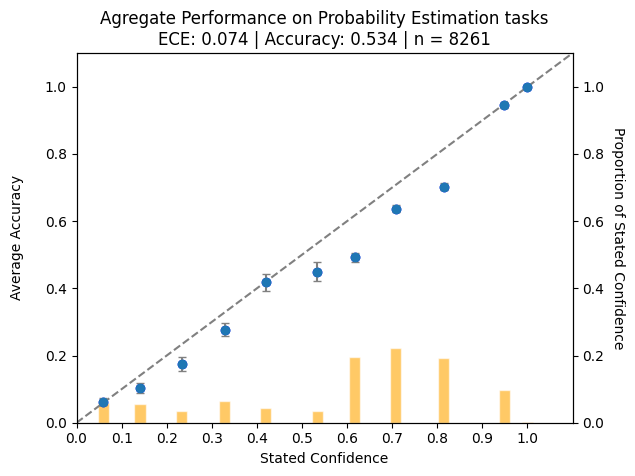

<Figure size 640x480 with 0 Axes>

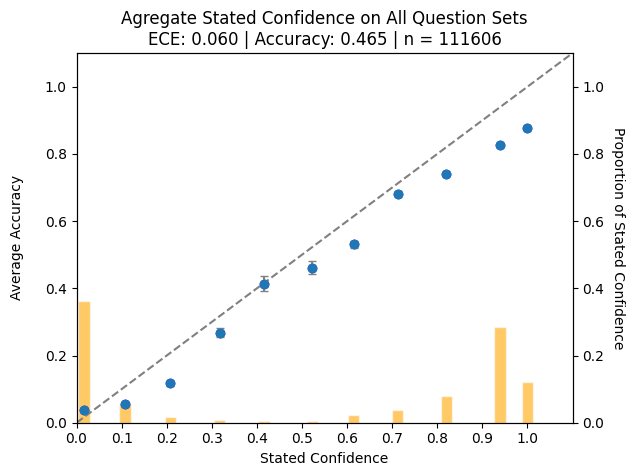

<Axes: title={'center': 'Agregate Stated Confidence on All Question Sets\nECE: 0.060 | Accuracy: 0.465 | n = 111606'}, xlabel='Stated Confidence', ylabel='Average Accuracy'>

<Figure size 640x480 with 0 Axes>

In [36]:
qset_types = {
    "Multiple Choice Questions": ['LSAT-AR', 'SAT-EN', 'SciQ'],
    "Factual": ['BoolQ', 'HaluEval'],
    "Probability Estimation": ['LifeEval']
}
save_path = Path(r"Plots\Main Plots")
agg_score = []
agg_conf = []
for type, qsets in qset_types.items():
    print(type, qsets)
    subset = combined_clean[combined_clean['Question Set'].isin(qsets)]
    print(f"    Subset Length: {len(subset) / 11}")
    title = f"Agregate Performance on {type} tasks"
    if type == "Multiple Choice Questions":
        scores, conf = expand_mcq(subset)
        #print(s.mean(), c.mean())

    else:
        scores = subset['Score']
        conf = subset['Stated Confidence Answer']
    agg_score.extend(scores)
    agg_conf.extend(conf)

    plot = calibration_plot(scores, conf, n_bins = 10, title = title, num_complete= len(scores), save_fig_to=save_path)
        
agg_title = "Agregate Stated Confidence on All Question Sets"

calibration_plot(agg_score, agg_conf, num_complete= len(agg_score), title = agg_title, save_fig_to=save_path)


Now for token calibration plots:

### Token Probability

Multiple Choice Questions ['LSAT-AR', 'SAT-EN', 'SciQ']
    Subset Length: 1254.0


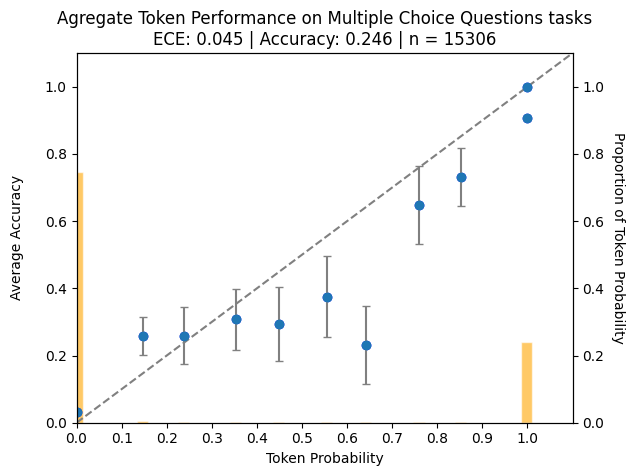

Factual ['BoolQ']
    Subset Length: 2503.0


<Figure size 640x480 with 0 Axes>

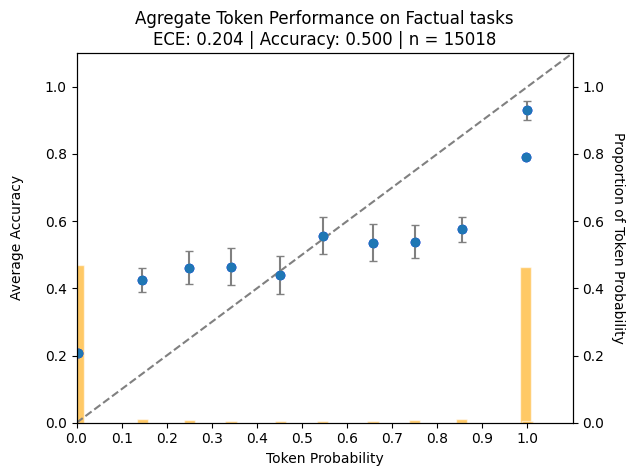

Probability Estimation ['LifeEval']
    Subset Length: 751.0


<Figure size 640x480 with 0 Axes>

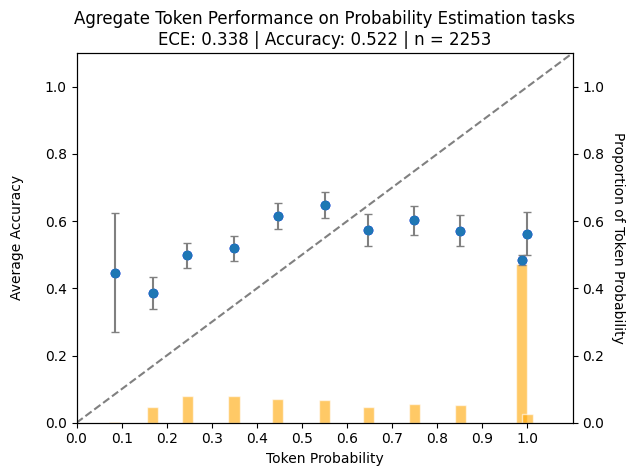

<Figure size 640x480 with 0 Axes>

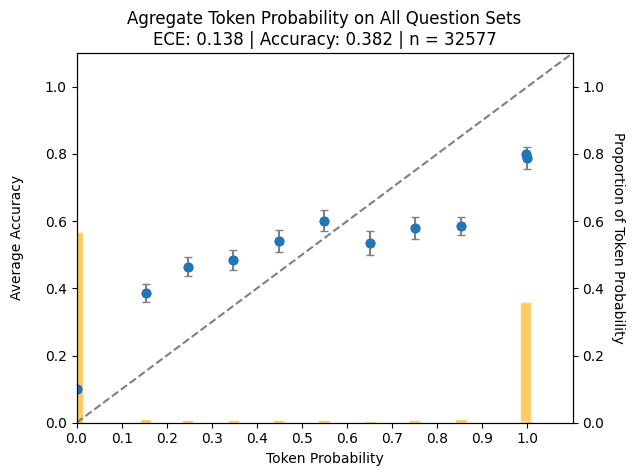

<Axes: title={'center': 'Agregate Token Probability on All Question Sets\nECE: 0.138 | Accuracy: 0.382 | n = 32577'}, xlabel='Token Probability', ylabel='Average Accuracy'>

<Figure size 640x480 with 0 Axes>

In [38]:
has_tokens = ['GPT-4o', 'Llama-3.1-70B', 'Llama-3.1-8B']

only_tokens = combined_clean[combined_clean['Model'].isin(has_tokens)]

only_tokens

qset_types = {
    "Multiple Choice Questions": ['LSAT-AR', 'SAT-EN', 'SciQ'],
    "Factual": ['BoolQ'],
    "Probability Estimation": ['LifeEval']
}

save_path = Path(r"Plots\Main Plots")
agg_score = []
agg_conf = []
agg_sc = []
for qtype, qsets in qset_types.items():
    print(qtype, qsets)
    subset = only_tokens[only_tokens['Question Set'].isin(qsets)]
    print(f"    Subset Length: {len(subset) / 3}")
    title = f"Agregate Token Performance on {qtype} tasks"
    if qtype == "Multiple Choice Questions":
        scores, conf = expand_tokens(subset)
        #print(s.mean(), c.mean())
    elif qtype == "Probability Estimation":
        scores = subset['Score']
        conf = subset['Token Probability Answer']
        sc = subset['Stated Confidence Answer']
    elif qtype == "Factual":
        scores, conf = expand_tokens(subset)
        
        sc = subset['Stated Confidence Answer']

        #print(s.mean(), c.mean())
    else:
        print("ERROR: Invalid Question Set Type!")
    agg_score.extend(scores)
    agg_conf.extend(conf)
    #agg_sc.extend(sc)
    plot = calibration_plot(scores, conf, n_bins = 10, title = title, num_complete= len(scores), x_label = "Token Probability", save_fig_to=  Path(r"Plots\Main Plots"))
agg_title = "Agregate Token Probability on All Question Sets"

calibration_plot(agg_score, agg_conf, num_complete= len(agg_score), title = agg_title, save_fig_to=save_path, x_label = "Token Probability")



### Stated Confidence V. Token Probability

In [135]:
def expand_mcq_tokens(data):
    """
    This function takes in a dataframe `data` and returns a dataframe which extracts the token / stated confidence values for each option
    The way it's written is pretty inefficient but I wanted clean readable code for debugging.
    """
    df = data.copy()
    sc_list = []
    tp_list = []
    qid_list = []
    qset_list = []
    model_list = []

    kind = ['Multiple Choice Question'] * len(df)

    for index, row in df.iterrows():
        qid = row['Question ID']
        qset = row['Question Set']
        model = row['Model']

        sc_a = row['Stated Confidence A']
        sc_b = row['Stated Confidence B']
        sc_c = row['Stated Confidence C']
        sc_d = row['Stated Confidence D']
        sc_e = row['Stated Confidence E']

        tp_a = row['Token Probability A']
        tp_b = row['Token Probability B']
        tp_c = row['Token Probability C']
        tp_d = row['Token Probability D']
        tp_e = row['Token Probability E']

        if qset == 'LSAT-AR': #only returns True for LSAT-AR
            sc = [sc_a, sc_b, sc_c, sc_d, sc_e]
            tp = [tp_a, tp_b, tp_c, tp_d, tp_e]
        else:
            sc = [sc_a, sc_b, sc_c, sc_d]
            tp = [tp_a, tp_b, tp_c, tp_d]
        
        mini_qid_list = [qid] * len(sc)
        mini_qset_list = [qset] * len(sc)
        mini_model_list = [model] * len(sc)

        sc_list.extend(sc)
        tp_list.extend(tp)
        qid_list.extend(mini_qid_list)
        qset_list.extend(mini_qset_list)
        model_list.extend(mini_model_list)




    kind_list = ['Multiple Choice Questions'] * len(sc_list)

    return pd.DataFrame({
    "Stated Confidence": sc_list,
    "Token Probability": tp_list,
    "Kind": kind_list,
    "Question Set": qset_list,
    "Question ID": qid_list,
    "Model": model_list
    }).dropna(axis = 0)



In [ ]:
sc_agg = []
tp_agg = []
kind_agg = []
qid_agg = []
qset_agg = []
model_agg = []


# For BoolQ we will have to the column for the chosen answer

for qset in all_qset_names:
    subset = only_tokens[only_tokens['Question Set'] == qset]

    if qset == 'BoolQ':
        # Get the stated confidence
        sc = subset['Stated Confidence Answer'] 
        # Get the token prob for either True/ False depending on the answer.
        # As a note, although we collect both True/ False probability it would be an unfair 
        # comparison in this case to assert that its confidence in True when the response was False would be
        # 1 - C(False). Therefore, I am only looking at the stated answer. This is not the case for all Qsets
        tp = subset.apply(lambda x: x[f"Token Probability {x['Answer']}"], axis =1)
        kind = ['2AFC'] * len(tp)
        model = subset['Model']
        qids = subset['Question ID']

    elif qset == 'HaluEval':
        continue # We don't do any analysis for HaluEval
    elif qset == 'LifeEval':
        sc = subset['Stated Confidence Answer'] 
        tp = subset['Token Probability Answer']
        kind = ['Probability Estimation'] * len(tp)
        qids = subset['Question ID']
        model = subset['Model']
    elif qset in mcq_qsets:
        #tp = subset['Stated Confidence Answer']
        #continue
        #s, sc = expand_mcq(subset)
        mcq_df = expand_mcq_tokens(subset)
        #Stated Confidence	Token Probability	Kind	Question Set	Question ID
        sc = mcq_df['Stated Confidence'].tolist()
        tp = mcq_df['Token Probability'].tolist()
        kind = mcq_df['Kind'].tolist()
        qset_list = mcq_df['Question Set'].tolist()
        qids = mcq_df['Question ID'].tolist()
        model = mcq_df['Model'].tolist()


        kind = ['Multiple Choice Questions'] * len(tp)
        
        #display(subset.head(3))

    qset_list = [qset] * len(tp)
    sc_agg.extend(sc)
    tp_agg.extend(tp)
    kind_agg.extend(kind)
    qset_agg.extend(qset_list)
    qid_agg.extend(qids)
    model_agg.extend(model)
    #print(f"{qset}: {len(sc)} {len(tp)} {len(kind)} {len(qset_list)} {len(qids)}") # Print statement for debugging


jp = pd.DataFrame({
    "Stated Confidence": sc_agg,
    "Token Probability": tp_agg,
    "Kind": kind_agg,
    "Question Set": qset_agg,
    "Question ID": qid_agg,
    "Model": model_agg
    })



jp

,Stated Confidence,Token Probability,Kind,Question Set,Question ID,Model
0,0.70,9.982993e-01,2AFC,BoolQ,0,GPT-4o
1,0.95,1.000000e+00,2AFC,BoolQ,2,GPT-4o
2,0.80,8.807971e-01,2AFC,BoolQ,3,GPT-4o
3,0.90,9.999982e-01,2AFC,BoolQ,4,GPT-4o
4,0.95,1.000000e+00,2AFC,BoolQ,5,GPT-4o
...,...,...,...,...,...,...
25063,1.00,9.999572e-01,Multiple Choice Questions,SciQ,998,Llama-3.1-8B
25064,0.00,1.120305e-05,Multiple Choice Questions,SciQ,999,Llama-3.1-8B
25065,0.20,8.334979e-06,Multiple Choice Questions,SciQ,999,Llama-3.1-8B
25066,0.80,9.999796e-01,Multiple Choice Questions,SciQ,999,Llama-3.1-8B


#### Scatter Plot:

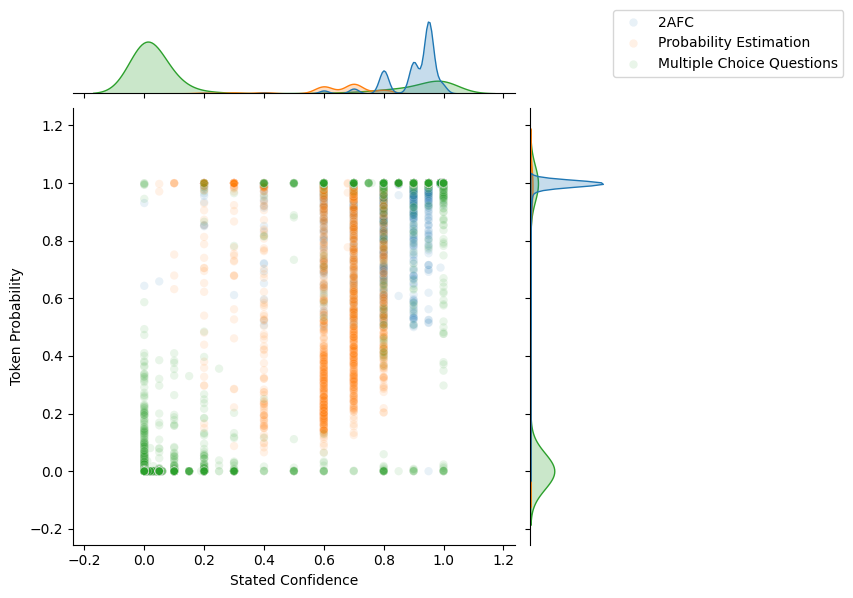

In [41]:

## Scatter Plot by Qset type:
g =sns.jointplot(jp, x='Stated Confidence', y='Token Probability', kind = 'scatter', alpha = 0.1, hue = 'Kind' )

# Combined Scatter Plot with Regresssion Line 
#g =sns.jointplot(jp, x='Stated Confidence', y='Token Probability', kind = 'reg')

# 2. Get the legend handles and labels *from* the joint axis
handles, labels = g.ax_joint.get_legend_handles_labels()

# 3. Remove the original, in-plot legend
g.ax_joint.get_legend().remove()


# 4. Add a *new* legend to the main figure
g.figure.legend(handles=handles, 
             labels=labels, 
             loc='upper left', 
             bbox_to_anchor=(1, 1)) # Places it outside

# 5. (The finicky part) Adjust the figure layout to make space
# You will have to tinker with 'right' until it looks good.
g.figure.subplots_adjust(right=1)


#### KDE Plot:

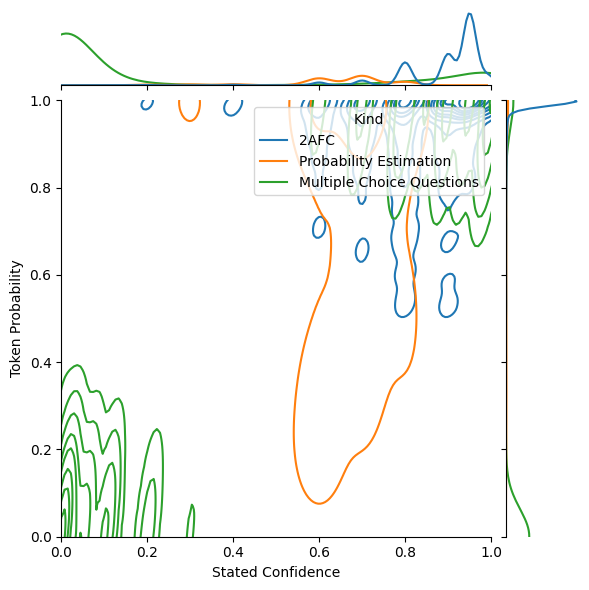

C:\Users\Noam Michael\AppData\Local\Temp\ipykernel_28604\636574396.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  g.figure.legend(handles=handles,


In [42]:
# KDE Plot:

#kind: Literal['scatter', 'kde', 'hist', 'hex', 'reg', 'resid']
g = sns.jointplot(jp, 
            x='Stated Confidence', 
            y='Token Probability', 
            kind='kde', 
            hue='Kind',
            
            )

plt.ylim(0, 1)
plt.xlim(0,1)
plt.show()

# 2. Get the legend handles and labels *from* the joint axis
handles, labels = g.ax_joint.get_legend_handles_labels()

# 3. Remove the original, in-plot legend
g.ax_joint.get_legend().remove()

# 4. Add a *new* legend to the main figure
g.figure.legend(handles=handles, 
             labels=labels, 
             loc='upper left', 
             bbox_to_anchor=(1, 1)) # Places it outside

# 5. (The finicky part) Adjust the figure layout to make space
# You will have to tinker with 'right' until it looks good.
g.figure.subplots_adjust(right=1)

**Observations**:

* __BoolQ__:
    * For BoolQ, we see that there are some instances where the model described less than 50% confidence (44 instances) these are all by Llama.

#### Investigating the lower right corner of SC v. TP plot

In [43]:
jp[
    (jp['Stated Confidence'] >= 0.99)  &
    (jp['Token Probability'] <= 0.05)
]

,Stated Confidence,Token Probability,Kind,Question Set,Question ID
10738,1.0,0.000325,Multiple Choice Questions,LSAT-AR,73
10739,1.0,0.000131,Multiple Choice Questions,LSAT-AR,73
10740,1.0,0.000126,Multiple Choice Questions,LSAT-AR,73
10741,1.0,0.000166,Multiple Choice Questions,LSAT-AR,73
10902,1.0,0.001990,Multiple Choice Questions,LSAT-AR,142
10906,1.0,0.000702,Multiple Choice Questions,LSAT-AR,142
12997,1.0,0.023475,Multiple Choice Questions,SAT-EN,166
12998,1.0,0.016475,Multiple Choice Questions,SAT-EN,166
12999,1.0,0.010926,Multiple Choice Questions,SAT-EN,166
22907,1.0,0.002746,Multiple Choice Questions,SciQ,457


In [44]:
bad = only_tokens[
    (only_tokens['Question ID'] == '73') &  
    (only_tokens['Question Set'] == 'LSAT-AR')  ]

content_str = bad.iloc[2]['Content']
print(content_str)

{
"Reasoning": "Given that Julio and Kevin both lead morning sessions, and Kevin and Rebecca must lead sessions on the same day, it's likely that Kevin and Rebecca lead the morning sessions on Thursday. Since Nessa must lead an afternoon session, and Lan and Olivia cannot lead sessions on the same day, the only possible afternoon session left for Nessa is Friday. Considering Julio's session must meet on an earlier day of the week than Olivia's, Julio's session could be on Wednesday, and Olivia's session could be on Friday. However, if Julio's session is on Wednesday, Lan's session cannot be on Wednesday morning because Kevin and Rebecca already occupy the Thursday morning sessions. Therefore, Lan's session must be on Thursday afternoon, making option A the only statement that could not be true.",
"Answer": "A",
"A": "0.0",
"B": "1.0",
"C": "1.0",
"D": "1.0",
"E": "1.0"
}


# Additional Analysis

In [147]:
combined_clean

,Reasoning,Answer,Stated Confidence Answer,Coerce,Content,Question ID,Model,Model Type,Question Set,Score,...,Stated Confidence Answer (MCQ),Token Probability True,Token Probability False,Token Probability Answer,Token Probability A,Token Probability B,Token Probability C,Token Probability D,Token Probability E,combined_name
0,The question is asking whether the production ...,False,0.6,True,"{\n ""Reasoning"": ""The question is asking wh...",0,Claude-Sonnet-3.7,Claude,BoolQ,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_BoolQ
2,This question is asking about phantom limb pai...,True,0.95,True,"{\n ""Reasoning"": ""This question is asking a...",2,Claude-Sonnet-3.7,Claude,BoolQ,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2_BoolQ
3,Harry Potter and the Escape from Gringotts is ...,True,0.98,True,"{\n ""Reasoning"": ""Harry Potter and the Esca...",3,Claude-Sonnet-3.7,Claude,BoolQ,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3_BoolQ
4,Hydroxyzine HCl (hydrochloride) and hydroxyzin...,True,0.98,True,"{\n ""Reasoning"": ""Hydroxyzine HCl (hydrochl...",4,Claude-Sonnet-3.7,Claude,BoolQ,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4_BoolQ
5,Barq's Root Beer is not a Pepsi product. It is...,False,0.98,True,"{\n ""Reasoning"": ""Barq's Root Beer is not a...",5,Claude-Sonnet-3.7,Claude,BoolQ,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5_BoolQ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82636,Predation is a biological process where one sp...,A,NaN,True,"{\n""Reasoning"": ""Predation is a biological pro...",995,Llama-3.1-8B,Llama,SciQ,1.0,...,0.95,NaN,NaN,NaN,0.999986,0.000003,0.000001,9.645942e-06,NaN,995_SciQ
82637,Short period comets are thought to originate f...,A,NaN,True,"{\n""Reasoning"": ""Short period comets are thoug...",996,Llama-3.1-8B,Llama,SciQ,1.0,...,0.95,NaN,NaN,NaN,0.999989,0.000004,0.000004,2.966547e-06,NaN,996_SciQ
82638,The question is asking about the developmental...,D,NaN,True,"{\n""Reasoning"": ""The question is asking about ...",997,Llama-3.1-8B,Llama,SciQ,1.0,...,1.00,NaN,NaN,NaN,0.000175,0.000042,0.000043,9.997405e-01,NaN,997_SciQ
82639,Atoms with unstable nuclei are those that have...,D,NaN,True,"{\n""Reasoning"": ""Atoms with unstable nuclei ar...",998,Llama-3.1-8B,Llama,SciQ,1.0,...,1.00,NaN,NaN,NaN,0.000015,0.000018,0.000010,9.999572e-01,NaN,998_SciQ


In [179]:
combined_clean['Stated Confidence Answer (MCQ)'] = combined_clean['Stated Confidence Answer (MCQ)'].astype(float)


res = combined_clean[(combined_clean['Model'] == 'GPT-o3') & 
                     (combined_clean['Question Set'] == 'SAT-EN')].sort_values('Stated Confidence Answer (MCQ)' )['Content'] #(combined_clean['Stated Confidence Answer (MCQ)'] <= 0.5)

print(res.iloc[0])


{
"Reasoning": "The exclamation “Who would have thought it possible?” shows Chandler’s former doubt, yet on reflection he “could remember many signs of future greatness,” implying that, in hindsight, the signs now appear obvious and Gallaher’s rise seems almost fated. The stress is on how retrospective vision makes success look inevitable, not on altered memories, prior confidence, or regret.",
"Answer": "A",
"A": 0.55,
"B": 0.25,
"C": 0.13,
"D": 0.07
}


# LifeEval Analysis

## Difficulty by QID

In [196]:
qid_to_rads(pd.Series([15]))[0]

np.int64(20)

In [ ]:
act = pd.read_csv(r"Formatted Benchmarks\PeriodLifeTable_2022_RawData.csv")
act

results = {}

for qid in range(808):
    min_age = get_age(qid)
    gender = 'Male' if qid < 404 else 'Female'
    rad = qid_to_rads(pd.Series([qid]))[0]
    best_age = min_age
    best_prob = compute_prob(min_age, R = rad, gender= gender, min_age = min_age, df = act)
    for age in range(min_age, 110):
        ap = compute_prob(age, R = rad, gender= gender, min_age = min_age, df = act)
        if ap > best_prob:
            best_age = age
            best_prob = ap

    results[qid]= {
        "Best Age": age,
        "Highest Probability": best_prob
    }



In [184]:
life_eval = combined_clean[combined_clean['Question Set'] == 'LifeEval']
life_eval.head()

,Reasoning,Answer,Stated Confidence Answer,Coerce,Content,Question ID,Model,Model Type,Question Set,Score,...,Stated Confidence Answer (MCQ),Token Probability True,Token Probability False,Token Probability Answer,Token Probability A,Token Probability B,Token Probability C,Token Probability D,Token Probability E,combined_name
5270,"For an American male at birth (0 years), I nee...",77,0.01,True,"{\n ""Reasoning"": ""For an American male at b...",0,Claude-Sonnet-3.7,Claude,LifeEval,0.049038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_LifeEval
5271,"For an American male at birth (0 years), I nee...",77,0.25,True,"{\n ""Reasoning"": ""For an American male at b...",1,Claude-Sonnet-3.7,Claude,LifeEval,0.244690,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1_LifeEval
5272,"For an American male at birth (0 years), I nee...",77,0.65,True,"{\n ""Reasoning"": ""For an American male at b...",2,Claude-Sonnet-3.7,Claude,LifeEval,0.487341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2_LifeEval
5273,"For an American male at birth (0 years), I nee...",77,0.68,True,"{\n ""Reasoning"": ""For an American male at b...",3,Claude-Sonnet-3.7,Claude,LifeEval,0.834496,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3_LifeEval
5274,For an American male who has already lived to ...,77,0.05,True,"{\n ""Reasoning"": ""For an American male who ...",4,Claude-Sonnet-3.7,Claude,LifeEval,0.049337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4_LifeEval


Lets clean it up to include what we want:

In [75]:
cols = ['Question ID', 'Model', 'Answer', 'Stated Confidence Answer','Token Probability Answer', 'Score']

data = life_eval[cols].copy()

data['Question ID'] = data['Question ID'].astype(int)
data['Score'] = data['Score'].astype(float)
data['Stated Confidence Answer'] = data['Stated Confidence Answer'].astype(float)


data['Age'] = data.apply(lambda x: get_age(x['Question ID']), axis = 1)
data['Radius'] = qid_to_rads(data['Question ID'])

# Calculate Overconfidence

# Calculate Calibration Error row wise so that we get ECE and Accuracy together in one groupby statement
data['Stated Calibration Error'] = abs(data['Stated Confidence Answer'] - data['Score']) 
data['Token Calibation Error'] = abs(data['Token Probability Answer'] - data['Score'])

data

grouped = data.groupby(['Model', 'Radius']).agg("mean")[['Answer', 'Stated Confidence Answer', 'Token Probability Answer', 'Score', 'Stated Calibration Error', 'Token Calibation Error']]


grouped = grouped.rename(columns = {
    "Answer": "Mean Answer",
    "Stated Confidence Answer": "Mean Stated Confidence",
    "Token Probability Answer": "Mean Token Probability",
    "Score": "Accuracy",
    "Stated Calibration Error": "Stated ECE",
    "Token Calibation Error": "Token ECE"
})

grouped['Stated Overconfidence'] = grouped['Mean Stated Confidence'] - grouped['Accuracy']
grouped['Token Overconfidence'] = grouped['Mean Token Probability'] - grouped['Accuracy']

grouped.reset_index(inplace=True)

## Overconfidence by Radii

### Stated Overconfidence

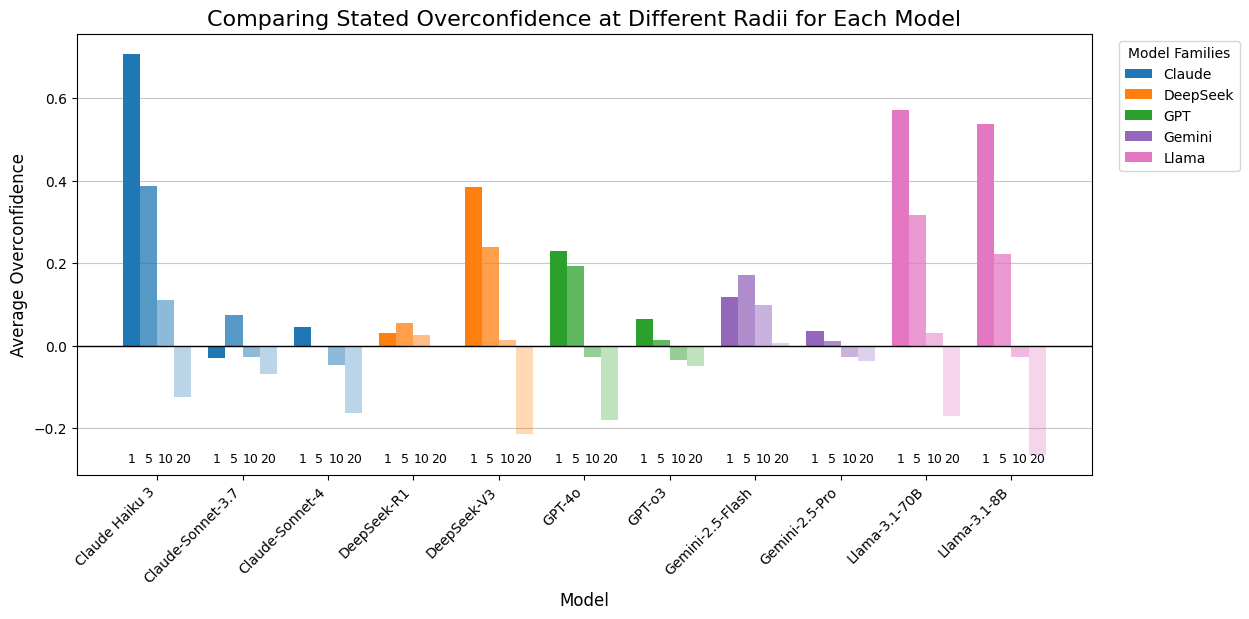

In [111]:

# --- 2. Data Preparation ---

# Function to get model family from its name
def get_model_family(model_name):
    if 'Claude' in model_name:
        return 'Claude'
    if 'DeepSeek' in model_name:
        return 'DeepSeek'
    if 'GPT' in model_name:
        return 'GPT'
    if 'Gemini' in model_name:
        return 'Gemini'
    if 'Llama' in model_name:
        return 'Llama'
    return 'Other'

# Add the 'Model Family' column to your DataFrame
grouped['Model Family'] = grouped['Model'].apply(get_model_family)

# Define the colors for each family (from your plot)
family_colors = {
    'GPT': '#2ca02c',       # Green
    'Claude': '#1f77b4',    # Blue
    'Gemini': '#9467bd',    # Purple
    'DeepSeek': '#ff7f0e',  # Orange
    'Llama': '#e377c2',     # Pink
    'Other': '#7f7f7f'      # Grey
}

# Define the shades (alpha) for each radius
# We'll map 1 to be the darkest (alpha=1.0) and 20 to be the lightest
radius_alphas = {1: 1.0, 5: 0.75, 10: 0.5, 20: 0.3}

# Get lists of unique models and radii
models = grouped['Model'].unique()
radii = sorted(grouped['Radius'].unique())
n_models = len(models)
n_radii = len(radii)


# --- 3. Plotting ---

fig, ax = plt.subplots(figsize=(14, 7))

# Define total width for one model's group of bars
group_width = 0.8
# Define width of a single bar
bar_width = group_width / n_radii
# Set the x-axis positions for the center of each group
x_positions = np.arange(n_models)

legend_handles = {}

# Loop over each model to plot its group of bars
for i, model in enumerate(models):
    # Get the data just for this model, sorted by radius
    model_data = grouped[grouped['Model'] == model].sort_values('Radius')
    
    # Loop over each radius to plot its specific bar
    for j, radius in enumerate(radii):
        bar_data = model_data[model_data['Radius'] == radius]
        
        if bar_data.empty:
            continue
            
        # Get the value, family, color, and alpha
        value = bar_data['Stated Overconfidence'].values[0]
        family = bar_data['Model Family'].values[0]
        color = family_colors.get(family, 'grey')
        alpha = radius_alphas.get(radius, 0.5)
        
        # Calculate the x-position for this specific bar
        # Start from the group's center (x_positions[i])
        # Move left by half the group_width
        # Move right by (j * bar_width) to get to this bar's left edge
        # Move right by half a bar_width to get to this bar's center
        x_pos = x_positions[i] - (group_width / 2) + (j * bar_width) + (bar_width / 2)
        
        # Plot the bar
        bar = ax.bar(
            x_pos,
            value,
            width=bar_width,
            color=color,
            alpha=alpha,
            label=family
        )
        
        # Store one bar per family for the legend
        if family not in legend_handles:
            legend_handles[family] = bar

# --- 4. Styling and Labels ---

# Set plot title and labels
ax.set_title('Comparing Stated Overconfidence at Different Radii for Each Model', fontsize=16)
ax.set_ylabel('Average Overconfidence', fontsize=12)
ax.set_xlabel('Model', fontsize=12)

# Set the x-axis ticks to be the model names
ax.set_xticks(x_positions)
ax.set_xticklabels(models, rotation=45, ha='right' )

# Add the '1 5 10 20' sub-labels
radius_label = ' '.join(map(str, radii))
radius_labels = ['1', '5', '10', '20']
for i in x_positions:
    shift = -bar_width * 2 + 0.5 * bar_width
    for r in radius_labels:
        xpos = i + shift
        ax.text(
            xpos,                      # x-position (center of the group)
            0.05,                  # y-position (just above the x-axis)
            r,           # The text
            ha='center',            # Horizontal alignment
            va='top',               # Vertical alignment
            transform= ax.get_xaxis_transform(), # Use axis coordinates for y
            fontsize=9,
            color='black'
        )

        shift += bar_width

# Add y=0 horizontal line
ax.axhline(0, color='black', linewidth=1.0)
# Add horizontal grid lines
ax.yaxis.grid(True, linestyle='-', alpha=0.7)
ax.set_axisbelow(True) # Put grid behind bars

# Create the legend
ax.legend(
    legend_handles.values(),
    legend_handles.keys(),
    title='Model Families',
    bbox_to_anchor=(1.02, 1), # Position legend outside the plot
    loc='upper left'
)

# Adjust layout to prevent labels from being cut off
plt.subplots_adjust(bottom=0.25, right=0.85)

# Show the plot
plt.show()

### Token Overconfidence

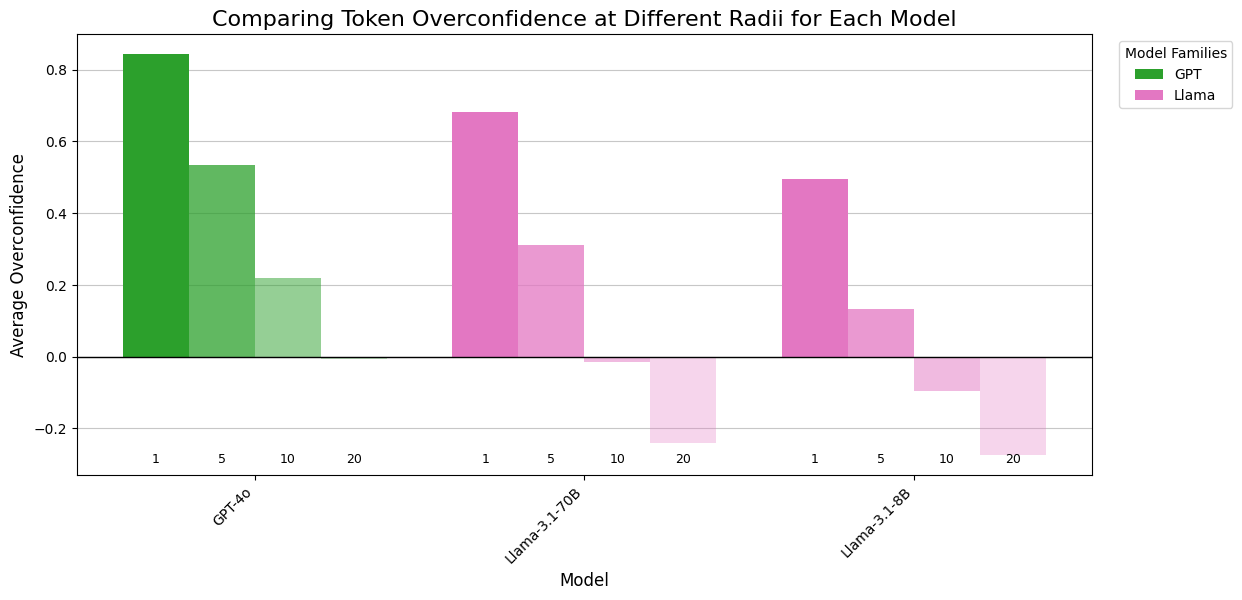

In [121]:
only_token_grouped = grouped[grouped['Model'].isin(has_tokens)].copy()

# Function to get model family from its name
def get_model_family(model_name):
    if 'Claude' in model_name:
        return 'Claude'
    if 'DeepSeek' in model_name:
        return 'DeepSeek'
    if 'GPT' in model_name:
        return 'GPT'
    if 'Gemini' in model_name:
        return 'Gemini'
    if 'Llama' in model_name:
        return 'Llama'
    return 'Other'

# Add the 'Model Family' column to your DataFrame
only_token_grouped['Model Family'] = only_token_grouped['Model'].apply(get_model_family)

# Define the colors for each family (from your plot)
family_colors = {
    'GPT': '#2ca02c',       # Green
    'Claude': '#1f77b4',    # Blue
    'Gemini': '#9467bd',    # Purple
    'DeepSeek': '#ff7f0e',  # Orange
    'Llama': '#e377c2',     # Pink
    'Other': '#7f7f7f'      # Grey
}

# Define the shades (alpha) for each radius
# We'll map 1 to be the darkest (alpha=1.0) and 20 to be the lightest
radius_alphas = {1: 1.0, 5: 0.75, 10: 0.5, 20: 0.3}

# Get lists of unique models and radii
models = only_token_grouped['Model'].unique()
radii = sorted(only_token_grouped['Radius'].unique())
n_models = len(models)
n_radii = len(radii)


# --- 3. Plotting ---

fig, ax = plt.subplots(figsize=(14, 7))

# Define total width for one model's group of bars
group_width = 0.8
# Define width of a single bar
bar_width = group_width / n_radii
# Set the x-axis positions for the center of each group
x_positions = np.arange(n_models)

legend_handles = {}

# Loop over each model to plot its group of bars
for i, model in enumerate(models):
    # Get the data just for this model, sorted by radius
    model_data = only_token_grouped[only_token_grouped['Model'] == model].sort_values('Radius')
    
    # Loop over each radius to plot its specific bar
    for j, radius in enumerate(radii):
        bar_data = model_data[model_data['Radius'] == radius]
        
        if bar_data.empty:
            continue
            
        # Get the value, family, color, and alpha
        value = bar_data['Token Overconfidence'].values[0]
        family = bar_data['Model Family'].values[0]
        color = family_colors.get(family, 'grey')
        alpha = radius_alphas.get(radius, 0.5)
        
        # Calculate the x-position for this specific bar
        # Start from the group's center (x_positions[i])
        # Move left by half the group_width
        # Move right by (j * bar_width) to get to this bar's left edge
        # Move right by half a bar_width to get to this bar's center
        x_pos = x_positions[i] - (group_width / 2) + (j * bar_width) + (bar_width / 2)
        
        # Plot the bar
        bar = ax.bar(
            x_pos,
            value,
            width=bar_width,
            color=color,
            alpha=alpha,
            label=family
        )
        
        # Store one bar per family for the legend
        if family not in legend_handles:
            legend_handles[family] = bar

# --- 4. Styling and Labels ---

# Set plot title and labels
ax.set_title('Comparing Token Overconfidence at Different Radii for Each Model', fontsize=16)
ax.set_ylabel('Average Overconfidence', fontsize=12)
ax.set_xlabel('Model', fontsize=12)

# Set the x-axis ticks to be the model names
ax.set_xticks(x_positions)
ax.set_xticklabels(models, rotation=45, ha='right')

# Add the '1 5 10 20' sub-labels
radius_label = ' '.join(map(str, radii))
radius_labels = ['1', '5', '10', '20']
for i in x_positions:
    shift = -bar_width * 2 + 0.5 * bar_width
    for r in radius_labels:
        xpos = i + shift
        ax.text(
            xpos,                      # x-position (center of the group)
            0.05,                  # y-position (just above the x-axis)
            r,           # The text
            ha='center',            # Horizontal alignment
            va='top',               # Vertical alignment
            transform= ax.get_xaxis_transform(), # Use axis coordinates for y
            fontsize=9,
            color='black'
        )

        shift += bar_width

# Add y=0 horizontal line
ax.axhline(0, color='black', linewidth=1.0)
# Add horizontal grid lines
ax.yaxis.grid(True, linestyle='-', alpha=0.7)
ax.set_axisbelow(True) # Put grid behind bars

# Create the legend
ax.legend(
    legend_handles.values(),
    legend_handles.keys(),
    title='Model Families',
    bbox_to_anchor=(1.02, 1), # Position legend outside the plot
    loc='upper left'
)

# Adjust layout to prevent labels from being cut off
plt.subplots_adjust(bottom=0.25, right=0.85)

# Show the plot
plt.show()

It seems that the Hard-Esay effect is prevelent when analyzing both stated and token overconfidence.